Team Members:

Barredez Rios, Carlos Andres - A01653183

Delgado Rios, Leonardo - A00827915

Hure, Marin Joseph - A01762723

Sánchez Pérez, Raúl Andrés - A01367635

## Importing Libraries.

---



---



In [1]:
# Importing all the libraries for the implementation.
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import seaborn as sns
sns.set()
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, RocCurveDisplay, precision_score, average_precision_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Importing all the models that we are going to use.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

#### Loading auxiliary functions.

---



In [2]:
# Function for calculating the Thresholds for outliers. Calculating the inside 50%.
def outlier_thresholds(df, col_name):
  data_qtles = df.describe()
  q1 = data_qtles[col_name]['25%']
  q3 = data_qtles[col_name]['75%']
  IQR = q3-q1
  up_limit = q3 + 1.5*IQR
  low_limit = q1 - 1.5*IQR

  return low_limit, up_limit

# Function to obtain the number of registers that a feature consider as outlier.
def outliers_encounters(df, col_name):
  low, up = outlier_thresholds(df, col_name)
  num_outliers = len(df[((df[col_name] < low) | (df[col_name] > up))])

  print(f'Number of outliers for {col_name}:', num_outliers)

# Function to obtain a table based on missing values on any feature.
def missing_values_table(dataframe, na_name = False):
  # Array of columns that have missing rows.
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
  # Number of missing values per feature.
  n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
  # Ratio of missing values and total values.
  ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
  # Making the table and showing it.
  missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
  print(missing_df, end="\n")

  if na_name:
    return na_columns

# Function to obtain if have impact on missing target based on missing table.
def missing_target(df, target, na_col):
  df_temp = df.copy()
  for col in na_cols:
    df_temp[col + '_NA_FLAG'] = np.where(df_temp[col].isnull(),1,0)
  na_flags = df_temp.loc[:, df_temp.columns.str.contains("_NA_")].columns
  print(na_flags)
  for col in na_flags:
    print(df_temp.groupby(col)[target].sum().head())
    print(pd.DataFrame({"TARGET_MEAN": df_temp.groupby(col)[target].mean(),
                          "Count": df_temp.groupby(col)[target].count()}), end="\n\n\n")

# Function to plot the correlation matrix.
def plot_correlation_matrix(matrix):
  plt.figure(figsize=(12,10))
  sns.heatmap(matrix, annot=True)
  plt.title("Correlation matrix heatmap")

# Function to make a classificator if the register is female or not.
def isFemale(row):
  if row["Sex"] == "female":
    return 1
  return 0

def isChild(row):
  if row["Age"] <= 15:
    return 1
  else :
    return 0

# Function to obtain MSE, based on the model and dataset.
def obtain_MSE(model, X, y):
  model.fit(X, y.values.ravel())

  some_data = X.iloc[:5]
  some_labels = y.iloc[:5]
  print("Predictions:", model.predict(some_data))
  print("Labels:", list(some_labels))

  survived_predictions = model.predict(X)
  mse = mean_squared_error(y, survived_predictions)
  print("MSE:", mse)
  print("RMSE:", np.sqrt(mse))

# Function to print the scores of a model.
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

# Function to evaluate the test dataset based on the best model (with parameters),
# and show the classification report and the confusion matrix.
def evaluate_best_models(model, X, type):
  final_predictions = model.predict(X)
  final_dataset["Survived"] = final_predictions

  # Switch to save the best parameters for each model.
  match type:
    case 1:
      final_dataset.to_csv("DecisionTreePredictions.csv", header = True, index = False)
    case 2:
      final_dataset.to_csv("RandomForestPredictions.csv", header = True, index = False)
    case 3:
      final_dataset.to_csv("kNNPredictions.csv", header = True, index = False)
    case 4:
      final_dataset.to_csv("SVCPredictions.csv", header = True, index = False)
    case 5:
      final_dataset.to_csv("LogisticRegressionPredictions.csv", header = True, index = False)

  print('----------------- MEAN -----------------')
  print('Mean_test_score :', model.cv_results_['mean_test_score'].mean())
  print('Std_test_score :', model.cv_results_['std_test_score'].mean())
  print('----------------- ONLY 1 -----------------')
  print('Mean_test_score :', model.cv_results_['mean_test_score'][0])
  print('Std_test_score :', model.cv_results_['std_test_score'][0])

## Load Dataset Based on Datasets from GitHub repository.

---



---



In [3]:
# Loading the all the datasets (train, test and true labels of test).
train_titanic_df = pd.read_csv("https://raw.githubusercontent.com/LeoDelgado23/TitanicClassificationIA23/main/DataSets/train.csv", sep = ",")
test_titanic_df = pd.read_csv("https://raw.githubusercontent.com/LeoDelgado23/TitanicClassificationIA23/main/DataSets/test.csv", sep = ",")
final_dataset = pd.read_csv("https://raw.githubusercontent.com/LeoDelgado23/TitanicClassificationIA23/main/DataSets/gender_submission.csv", sep = ",")

# Verify loading into env showing its shapes.
train_titanic_df.shape, test_titanic_df.shape, final_dataset.shape

((891, 12), (418, 11), (418, 2))

## 1) Exploration and Data Pre-processing.

---



---



#### a) Distributions.

---


<ul>
 <li> Verify if the data is balanced in the classes in which it should be separate the data.
 </li>
 <li> Analyze the distribution of categorical data and its relationship with the class "survived." Begin to identify characteristics relevant to an accurate classification.
 </li>
 <li> Understand the distribution of numerical data and determine if it is necessary to apply normalization or standardization processes.
 </li>
</ul>

In [4]:
# Reorganizing dataset only for visual purposes.
train_titanic_df = train_titanic_df[["PassengerId", "Name", "Sex", "Age", "Pclass", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked", "Survived"]]

In [5]:
# Showing information about the dataset.
train_titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Name         891 non-null    object 
 2   Sex          891 non-null    object 
 3   Age          714 non-null    float64
 4   Pclass       891 non-null    int64  
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
 11  Survived     891 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<br> We observe what are the features/variables that our dataset is made from, know the name for each feature, the type of each one of them and show us the number of registers (rows) that each feature has, as well as the total number of registers of the dataset. Thanks to the overview provided by the kaggle description, we know which features are categorical and which are numerical. </br>

In [6]:
# Show how distributed "Sex" feature is within the dataset.
train_titanic_df["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [7]:
# Show how distributed "Pclass" feature is within the dataset.
train_titanic_df["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [8]:
# Show how distributed "Ticket" feature is within the dataset.
train_titanic_df["Ticket"].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

In [9]:
# Show how distributed "Cabin" feature is within the dataset.
train_titanic_df["Cabin"].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [10]:
# Show how distributed "Embarked" feature is within the dataset.
train_titanic_df["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [11]:
# Show how many of the passengers are chidren.
children = train_titanic_df.apply(isChild, axis = 1)
children.value_counts()

0    808
1     83
dtype: int64

Here we can see how is the distribution behaviour within the features that are categoricals or are an object instead of numerical, meaning that we can see the Embarked have three ports and the number of passengers for each one, the Cabins and the number of passengers that were assign to the cabin, the ticket information and the sex of each passenger.<br></br>


In [12]:
# Showing statistics about the dataset.
train_titanic_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000


Now knowing the statistics of the numerical features, we can see some measure of central tendency (mena) and some measures of dispersion (range), as well as tge IQ values. Based on this table, we can make some assumptions about which features have missing values or needed to be examined in order to confirm if the value of the feature is correct, an outlier and the missing values as well.
<br></br>
On the other hand, the following charts are going to help us understand the behaviour of the distribution among the numerical features, with this charts we can see if any of the features have outliers and the form of the distribution (if it is normal, skewed, etc) through the whole dataset. And we can start to contemplate if any of the features need to be applied any normalization or standarization process.

array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'Fare'}>],
       [<Axes: title={'center': 'Survived'}>, <Axes: >, <Axes: >]],
      dtype=object)

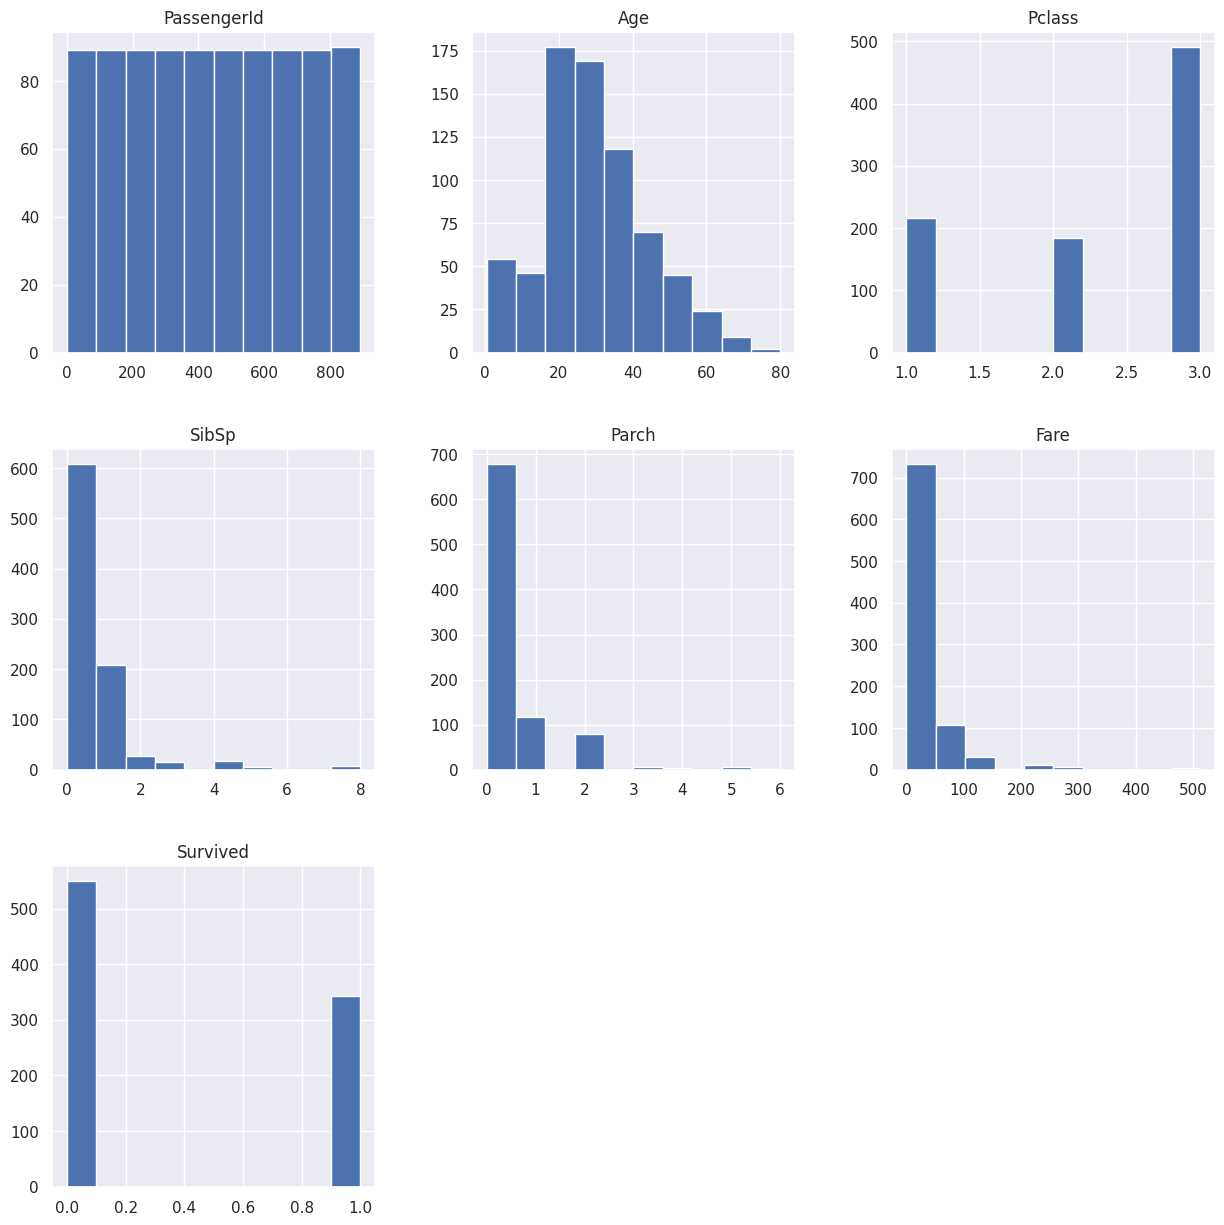

In [13]:
# Showing the distribution throughout the dataset.
train_titanic_df.hist(figsize = (15, 15), bins = 10)

But also, we are going to see if the features are distributed between our target class (Survived or NOT Survived), seeing as well the distribution of each feature based on the target class, helping us to undersand if we have a balance or unbalanced dataset.

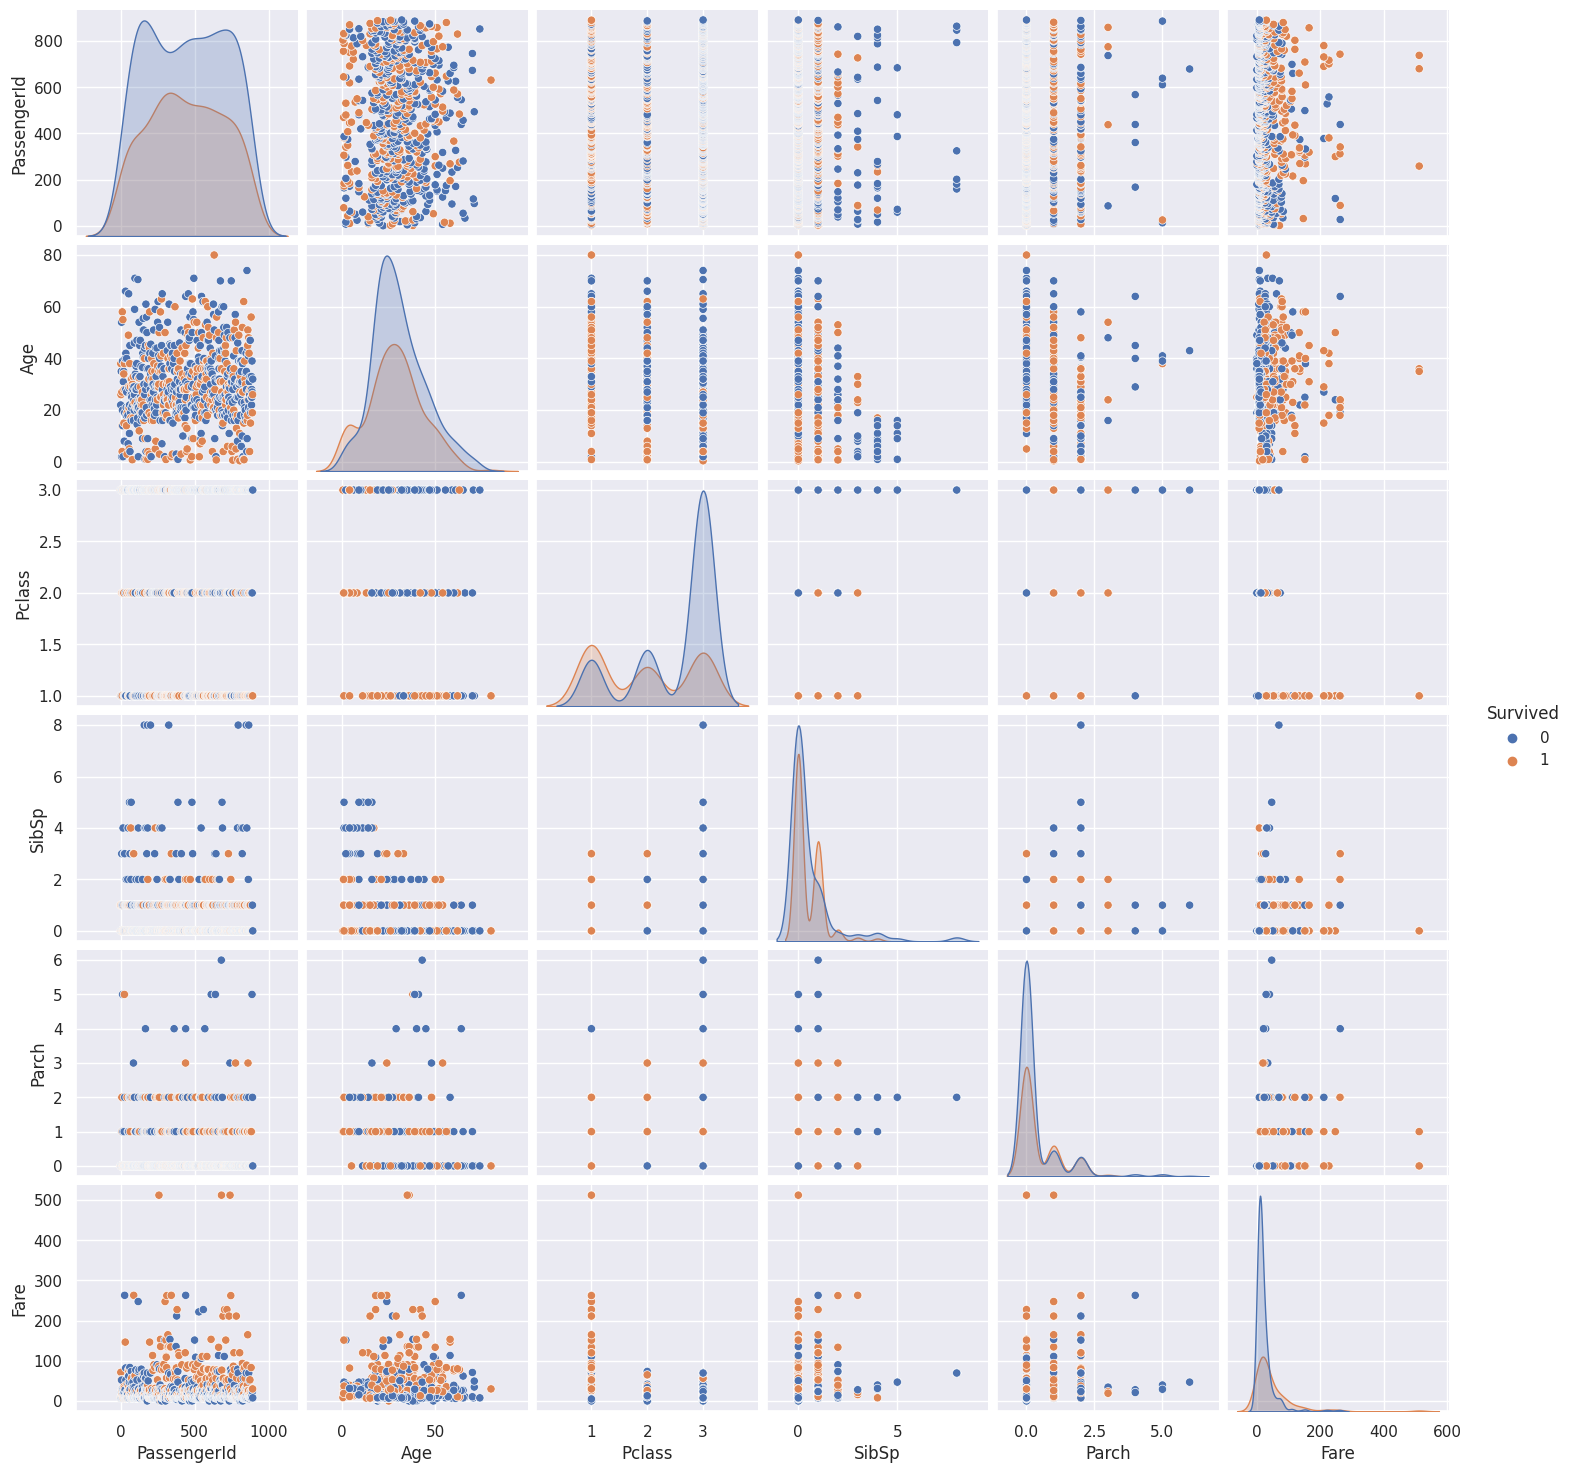

In [14]:
sns.pairplot(train_titanic_df, hue = 'Survived')

<Axes: xlabel='Survived', ylabel='Fare'>

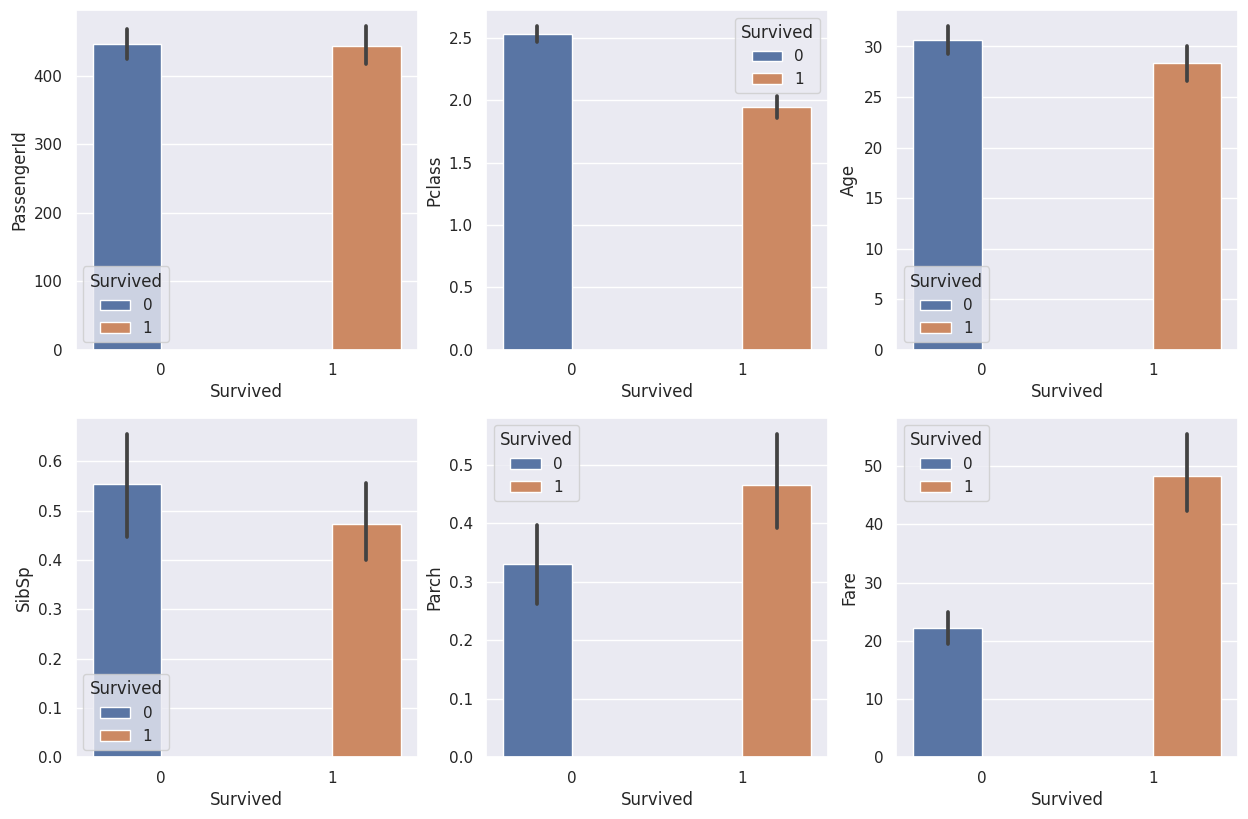

In [15]:
# Showing how each feature is distributed is our target class.
plt.figure(figsize=(15, 15))
plt.subplot(3,3,1)
sns.barplot(x = 'Survived', y = 'PassengerId', data = train_titanic_df, hue = "Survived")
plt.subplot(3,3,2)
sns.barplot(x = 'Survived', y = 'Pclass', data = train_titanic_df, hue = "Survived")
plt.subplot(3,3,3)
sns.barplot(x = 'Survived', y = 'Age', data = train_titanic_df, hue = "Survived")
plt.subplot(3,3,4)
sns.barplot(x = 'Survived', y = 'SibSp', data = train_titanic_df, hue = "Survived")
plt.subplot(3,3,5)
sns.barplot(x = 'Survived', y = 'Parch', data = train_titanic_df, hue = "Survived")
plt.subplot(3,3,6)
sns.barplot(x = 'Survived', y = 'Fare', data = train_titanic_df, hue = "Survived")

Once we see the distribution of the numerical features through our target class, we made some calculation in order to understand how the distribution is behaving amoung our categorical features vs target class. So, we make the calculations of the gender survival rate, the embark survival rate and the economic status survival rate.

In [16]:
# Verify if the data is balanced in the target classes.
no_survived, survived = train_titanic_df['Survived'].value_counts()

print('% people DID NOT survived :', (no_survived / (no_survived + survived) * 100))
print('% people DID survived :', (survived / (no_survived + survived) * 100), '\n')

# Verify each gender percent of survivals.
women_survived = train_titanic_df.loc[train_titanic_df.Sex == "female"]['Survived']
rate_women = sum(women_survived)/len(women_survived)

men_survived = train_titanic_df.loc[train_titanic_df.Sex == "male"]['Survived']
rate_men = sum(men_survived)/len(men_survived)

print("% of women who survived:", rate_women * 100)
print("% of men who survived:", rate_men * 100, "\n")

# Verify children percent of survivals.
children_survived = train_titanic_df.loc[train_titanic_df.Age <= 15]['Survived']
rate_children = sum(children_survived)/len(children_survived)

print("% of children who survived:", rate_children * 100, "\n")

# Verify percent of survivals per PClass.
class_one_survived = train_titanic_df.loc[train_titanic_df.Pclass == 1]['Survived']
rate_class_one = sum(class_one_survived)/len(class_one_survived)

class_two_survived = train_titanic_df.loc[train_titanic_df.Pclass == 2]['Survived']
rate_class_two = sum(class_two_survived)/len(class_two_survived)

class_three_survived = train_titanic_df.loc[train_titanic_df.Pclass == 3]['Survived']
rate_class_three = sum(class_three_survived)/len(class_three_survived)

print("% of first class who survived:", rate_class_one * 100)
print("% of second class who survived:", rate_class_two * 100)
print("% of third class who survived:", rate_class_three * 100, "\n")

# Verify percent of survivals per Embark.
embark_c_survived = train_titanic_df.loc[train_titanic_df.Embarked == 'C']['Survived']
rate_embark_c = sum(embark_c_survived)/len(embark_c_survived)

embark_q_survived = train_titanic_df.loc[train_titanic_df.Embarked == 'Q']['Survived']
rate_embark_q = sum(embark_q_survived)/len(embark_q_survived)

embark_s_survived = train_titanic_df.loc[train_titanic_df.Embarked == 'S']['Survived']
rate_embark_s = sum(embark_s_survived)/len(embark_s_survived)

print("% of people who embarked on C who survived:", rate_embark_c * 100)
print("% of people who embarked on Q who survived:", rate_embark_q * 100)
print("% of people who embarked on S who survived:", rate_embark_s * 100)

% people DID NOT survived : 61.61616161616161
% people DID survived : 38.38383838383838 

% of women who survived: 74.20382165605095
% of men who survived: 18.890814558058924 

% of children who survived: 59.036144578313255 

% of first class who survived: 62.96296296296296
% of second class who survived: 47.28260869565217
% of third class who survived: 24.236252545824847 

% of people who embarked on C who survived: 55.35714285714286
% of people who embarked on Q who survived: 38.961038961038966
% of people who embarked on S who survived: 33.69565217391305


#### b) Missing values.

---


<ul>
 <li> Identify and visualize missing data.
 </li>
 <li> Decide which characteristics require imputations and which do not. Justify the decision and remove unselected columns.
 </li>
 <li> Apply imputation techniques for missing data. Select the best technique and justify the choice.
 </li>
</ul>

In the previous section, we saw the distribution of our dataset and how our dataset is made up. Also, we could see that our dataset has missing values ​​and some features that require analysis on their values ​​since they could have been omitted at the time of the register. <br></br>
So, we are going to make the analysis of the missing values and start to see the best way to fill those values and/or if they contribute on our classification.

In [17]:
# Identify if any feature has missing values.
total_registers = train_titanic_df["PassengerId"].count()
print(train_titanic_df.isnull().sum(), "\n")
print("% of Missing values for Age :", (train_titanic_df["Age"].isnull().sum()/total_registers))
print("% of Missing values for Cabin :", (train_titanic_df["Cabin"].isnull().sum()/total_registers))
print("% of Missing values for Embarked :", (train_titanic_df["Embarked"].isnull().sum()/total_registers))

PassengerId      0
Name             0
Sex              0
Age            177
Pclass           0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Survived         0
dtype: int64 

% of Missing values for Age : 0.19865319865319866
% of Missing values for Cabin : 0.7710437710437711
% of Missing values for Embarked : 0.002244668911335578


Based on this information we instantly recognize that would not be wise to use the cabin feature for our final features because it has 77.10% of missing values, so making and imputation or filling the missing values won't give us a notion of true values. Also, since our numver of missing values for Age and Embarked features we will be able to make imputations on these values. Mostly because we consider this two feature, will indeed have certain impact on our predictions. <br></br>
The following charts are a more visual representation of the previous execution, that allow us to view the number of missing values per feature and if the missing values are distributed equally through the dataset index registers or if the missing values had been ommited only at the beginning/last registers.

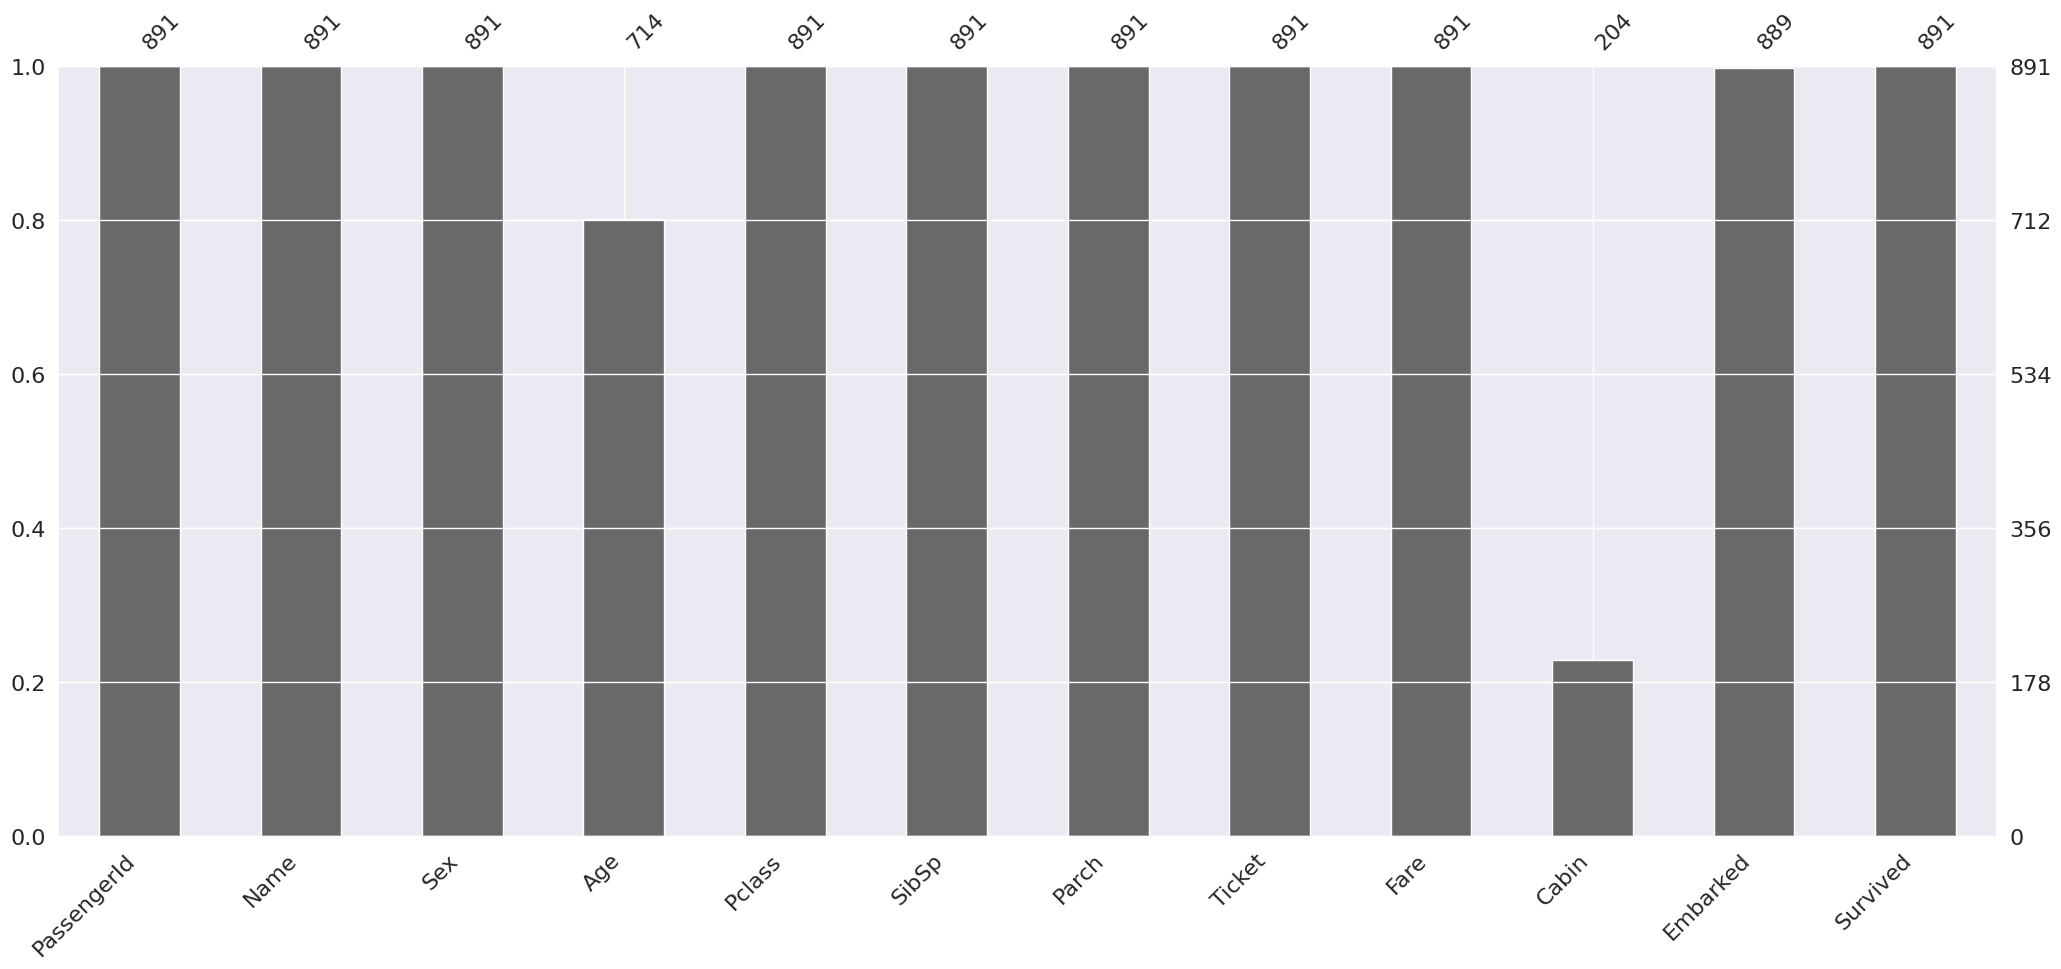

In [18]:
# Verify the missing values of the dataset.
missing_values = msno.bar(train_titanic_df)

<Axes: >

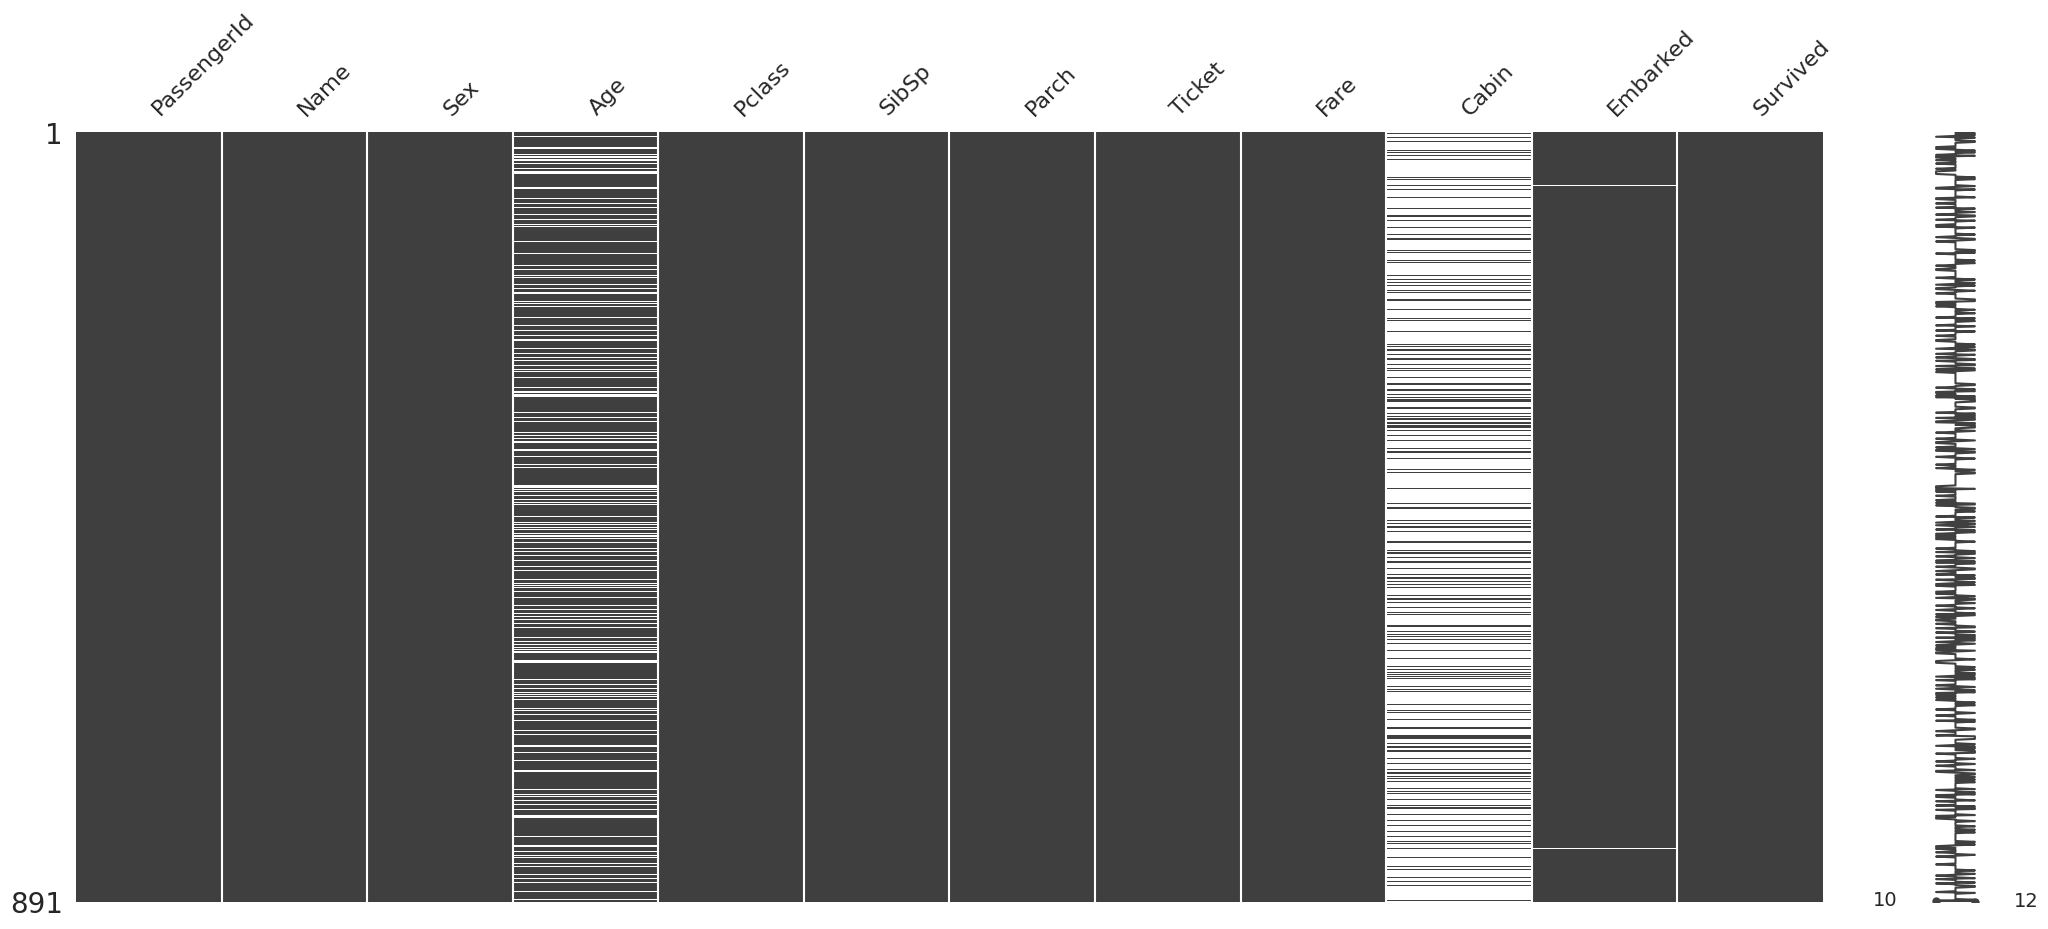

In [19]:
# Verify the missing values of the dataset per index or register.
msno.matrix(train_titanic_df)

Once we know the missing values pattern of each feature and already know which of this feature we are going to apply some kind of imputation, well we have to know if we have outliers, since some of the imputation tecniques include filling NaN values with mean, we don't want to use metrics that won't help us to find the best classification model. <br></br>
So, we calculate the thresholds, this ones would give us parameters to know if we have some outliers for each feature, meaning that if any of our values are outside this threshold range the could be potentially an outlier.

In [20]:
# Obtain the thresholds that will say if a value is an outlier.
outlier_train_titanic_df = train_titanic_df[["Pclass","Age","SibSp","Parch","Fare"]]

for i in outlier_train_titanic_df.columns:
    print("Thresholds of {} : ({:.2f}, {:.2f})".format(i, *outlier_thresholds(outlier_train_titanic_df, i)))

Thresholds of Pclass : (0.50, 4.50)
Thresholds of Age : (-6.69, 64.81)
Thresholds of SibSp : (-1.50, 2.50)
Thresholds of Parch : (0.00, 0.00)
Thresholds of Fare : (-26.72, 65.63)


After making the process of obtaining how many values are outside of the threshold range, the results are shown in the following print. It is telling us that we have some features with outliers, but here we can have a couple of observations for this values, since based on this thresholds and the range calculated previously for our dataset, we won't consider any value as outlier. <br></br>
Since, our max age is 80, any age higher than 64.81 would be within this range (64.81 <= 80) meaning for us something rational. Since we consider that in the Titanic's incident time period was common to have many children we consider the Parch values are within an accepted range, as well as the Fare, because a higher economic class would be able to pay a higher ticket fare.

In [21]:
# Verify number of outliers for numerical features.
outliers_encounters(train_titanic_df, "Pclass")
outliers_encounters(train_titanic_df, "Age")
outliers_encounters(train_titanic_df, "SibSp")
outliers_encounters(train_titanic_df, "Parch")
outliers_encounters(train_titanic_df, "Fare")

Number of outliers for Pclass: 0
Number of outliers for Age: 11
Number of outliers for SibSp: 46
Number of outliers for Parch: 213
Number of outliers for Fare: 116


In [22]:
# Obtain a missing values per feature table.
na_cols = missing_values_table(train_titanic_df, True)

          n_miss  ratio
Cabin        687  77.10
Age          177  19.87
Embarked       2   0.22


In [23]:
missing_target(train_titanic_df, "Survived", na_cols)

Index(['Age_NA_FLAG', 'Cabin_NA_FLAG', 'Embarked_NA_FLAG'], dtype='object')
Age_NA_FLAG
0    290
1     52
Name: Survived, dtype: int64
             TARGET_MEAN  Count
Age_NA_FLAG                    
0               0.406162    714
1               0.293785    177


Cabin_NA_FLAG
0    136
1    206
Name: Survived, dtype: int64
               TARGET_MEAN  Count
Cabin_NA_FLAG                    
0                 0.666667    204
1                 0.299854    687


Embarked_NA_FLAG
0    340
1      2
Name: Survived, dtype: int64
                  TARGET_MEAN  Count
Embarked_NA_FLAG                    
0                    0.382452    889
1                    1.000000      2




At this moment, we already identify that since the Embarked feature is only missing two values and since this specific feature its categorical, its okay to fill them with the mode, noting that won't represent a high impact on the distribution of this feature. <br></br>
On the other hand, the age value its showing us kind of a normal distribution, slightly a skewed distribution, meaning that our median as well as our mean are going to be near each other, and since our number of missing values its greater almost at 20%, in this case we are going to use our median value to fill the missing values of the age feature, and to manage the potentially outlier values mentioned previously.

In [24]:
# Fill the missing values of the features that we are going to keep.
train_titanic_df['Age'].fillna(train_titanic_df['Age'].median(), inplace=True)
train_titanic_df['Embarked'].fillna(train_titanic_df['Embarked'].mode()[0], inplace=True)

#### c) Correlation analysis.

---


<ul>
 <li> Perform a correlation analysis to decide which characteristics should kept and which ones to discard.
 </li>
</ul>

<ipython-input-26-ab4e8bbcb43d>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train_titanic_df.corr()


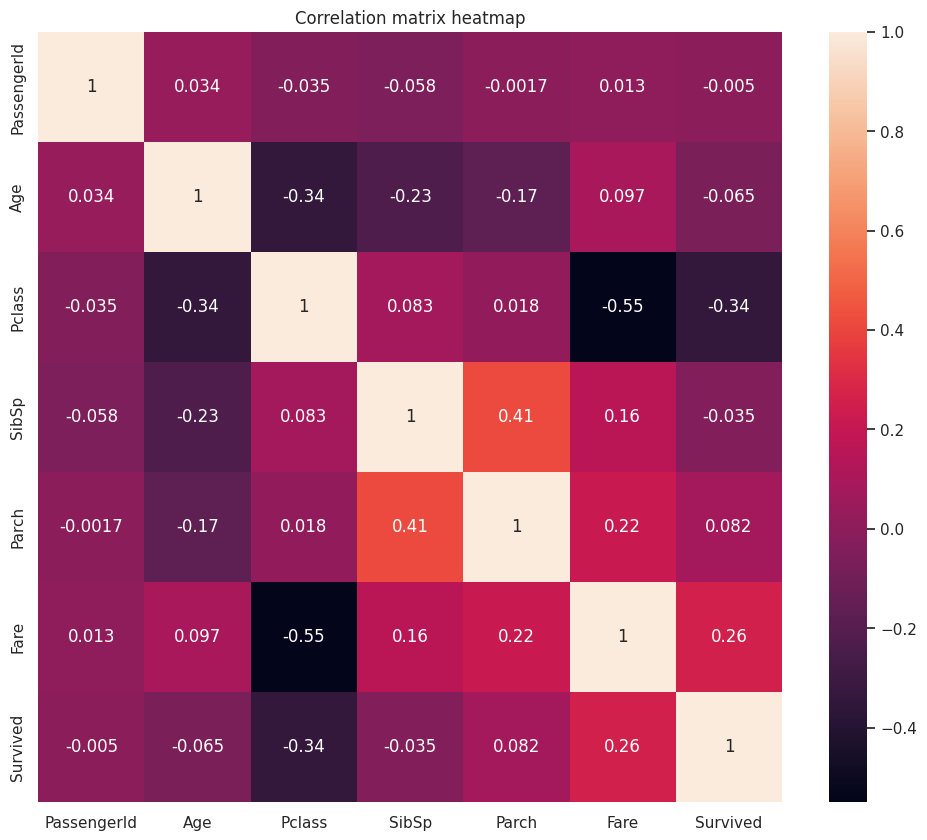

In [26]:
# Display an initial correlation matrix of the dataset.
corr_matrix = train_titanic_df.corr()
plot_correlation_matrix(corr_matrix)

In [27]:
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.064910
Pclass        -0.338481
Name: Survived, dtype: float64

#### d) Data Transformation.

---


<ul>
 <li> Convert categorical data to numerical data. Explore different methods and select the most suitable one. Justify the choice.
 </li>
</ul>

Based on the previous two sections where we identify the features with missing values and the correlation matrix, we already knew which features we don't want to keep, so we are dropping "PassengerId", "Name", "Ticket", "Cabin" and "Sex". PassengerId, Name and Ticket were drop because it gives us no relevant information in order to have an impact on our final classificator, the Cabin feature was drop because the number of missing values its almost the entire number of rows of the dataset, last but nos least, the sex feature was drop because we transform the feature into a binary one, containing if the passenger is a female or not. <br></br>
Mostly because of the initial distribution of our dataset, where we found that being a female has higher survival probabilities than being a male. The same approach was applied to Embarked feature, and also we applied a binary transformation, telling us if it came from of a specific port of not.

In [28]:
# Transforming sex categories into binary here only to appear in plotting charts.
train_titanic_df["isFemale"] = train_titanic_df.apply(isFemale, axis = 1)

# Transforming Embarked feature as binary.
train_titanic_df = pd.get_dummies(train_titanic_df, columns=['Embarked'], prefix=['Embarked'])

# Drop the features that we are not going to use and review the transformation of Sex.
train_titanic_df = train_titanic_df.drop(["PassengerId", "Name", "Sex", "Ticket", "Cabin"], axis = 1)
train_titanic_df["isFemale"].value_counts()

0    577
1    314
Name: isFemale, dtype: int64

<Axes: xlabel='Survived', ylabel='isFemale'>

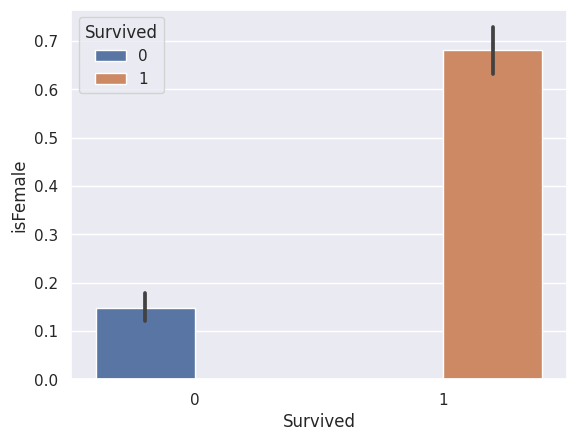

In [29]:
sns.barplot(x = 'Survived', y = 'isFemale', data = train_titanic_df, hue = "Survived")

In [31]:
# Make a standarization on the features.
scaler = StandardScaler()
features = ['Age', 'SibSp', 'Parch', 'Fare']
train_titanic_df[features] = scaler.fit_transform(train_titanic_df[features])

# Organizing our features within the dataset.
train_titanic_df = train_titanic_df[["Age", "Pclass", "SibSp", "Parch", "Fare", "Embarked_C", "Embarked_Q", "Embarked_S", "isFemale", "Survived"]]

In [32]:
# Showing information about the dataset.
train_titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         891 non-null    float64
 1   Pclass      891 non-null    int64  
 2   SibSp       891 non-null    float64
 3   Parch       891 non-null    float64
 4   Fare        891 non-null    float64
 5   Embarked_C  891 non-null    uint8  
 6   Embarked_Q  891 non-null    uint8  
 7   Embarked_S  891 non-null    uint8  
 8   isFemale    891 non-null    int64  
 9   Survived    891 non-null    int64  
dtypes: float64(4), int64(3), uint8(3)
memory usage: 51.5 KB


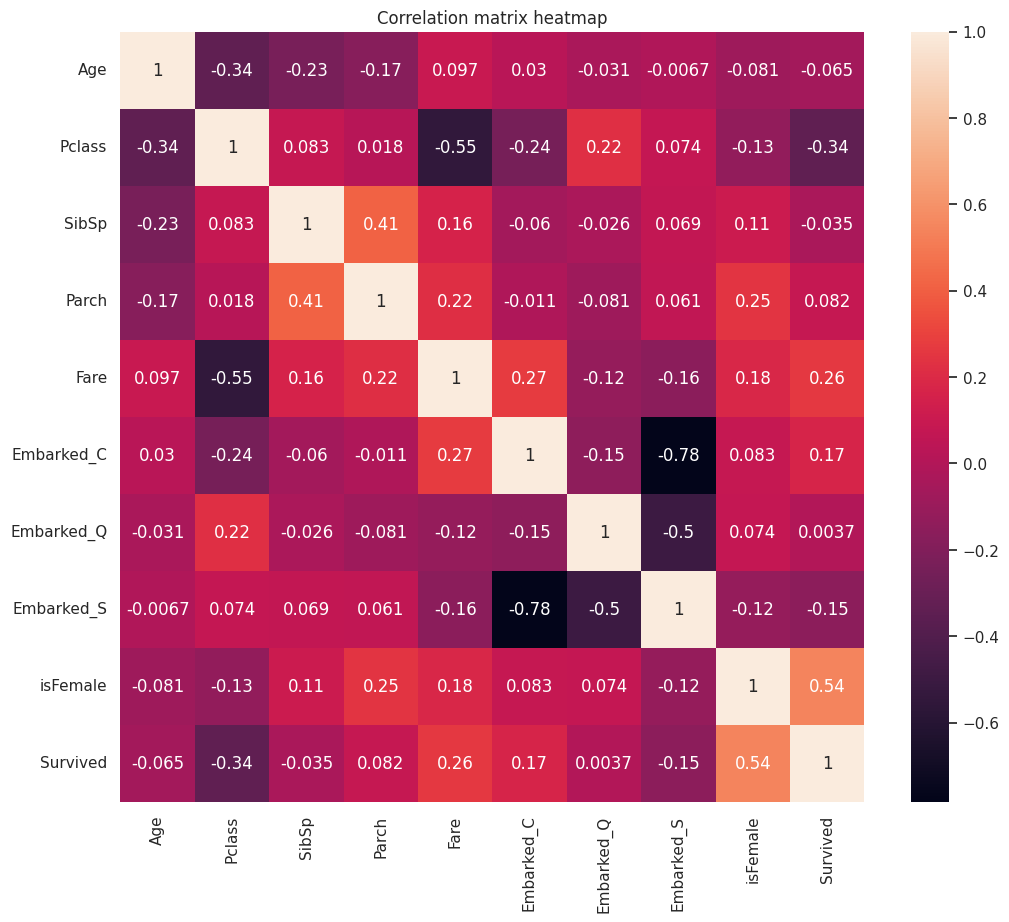

In [33]:
# Display our final correlation matrix of the dataset.
corr_matrix = train_titanic_df.corr()
plot_correlation_matrix(corr_matrix)

In [34]:
corr_matrix["Survived"].sort_values(ascending=False)

Survived      1.000000
isFemale      0.543351
Fare          0.257307
Embarked_C    0.168240
Parch         0.081629
Embarked_Q    0.003650
SibSp        -0.035322
Age          -0.064910
Embarked_S   -0.149683
Pclass       -0.338481
Name: Survived, dtype: float64

Once we applied the transformation of some features, we can clearly notice how specific categories of Embarked have a higher correlation in the target class, as well as being female. From here we can select only the features that we consider will have a greater impact on our final classifier and will give us th best score.

## 2) Classification.

---



---




#### a) Classificators Selection.

---


<ul>
 <li> Choose three classification algorithms to be used in the project. Justify the selection of each algorithm.
 </li>
</ul>

In [35]:
# Split the dataset into features and target class.
X_train_titanic_df = train_titanic_df.drop(["Survived"], axis = 1)
y_train_titanic_df = train_titanic_df[["Survived"]]

---
---
---
---
**Logistic Regression:**

Logistic Regression is a simple yet effective algorithm for binary classification problems, making it a suitable choice for predicting whether a passenger survived or not. It's interpretable, works well with linearly separable data, and provides probabilities as outputs, which can be useful for understanding the model's confidence in predictions.

**Decision Tree Classifier:**

Decision Trees are powerful and easy-to-understand models. They can capture complex non-linear relationships in the data. In the case of the Titanic dataset, Decision Trees can potentially capture rules like "women and children first" as they recursively split the data based on feature values. However, they may overfit, so proper tuning is necessary.

**Random Forest Classifier:**

Random Forest is an ensemble method that builds multiple decision trees and combines their predictions, reducing the risk of overfitting compared to a single Decision Tree. It's robust and can handle both categorical and numerical features effectively. It's often used for tabular data like the Titanic dataset and can capture more complex interactions between features.

**Support Vector Classifier (SVC):**

SVC is a powerful algorithm for classification tasks, especially when the data is not linearly separable. It can capture complex decision boundaries in high-dimensional space. While the Titanic dataset is relatively small and may not require such complexity, SVC is still a viable choice if you suspect non-linear relationships in the data.

**K-Nearest Neighbors (KNN) Classifier:**

KNN is a simple yet effective instance-based learning algorithm. It can capture local patterns in the data and is non-parametric, meaning it doesn't make strong assumptions about the data distribution. KNN can be useful when there are regions in the feature space where survivors or non-survivors tend to cluster together.

---
---
---
---



In [36]:
# Load a Logistic Regression model and evaluate the model.
log_reg = LogisticRegression()
obtain_MSE(log_reg, X_train_titanic_df, y_train_titanic_df)

Predictions: [0 1 1 1 0]
Labels: ['Survived']
MSE: 0.19977553310886645
RMSE: 0.4469625634310624


In [37]:
# Load a Decision Tree model and evaluate the model.
tree_class = DecisionTreeClassifier()
obtain_MSE(tree_class, X_train_titanic_df, y_train_titanic_df)

Predictions: [0 1 1 1 0]
Labels: ['Survived']
MSE: 0.020202020202020204
RMSE: 0.1421338109037403


In [38]:
# Load a Random Forest model and evaluate the model.
rf_class = RandomForestClassifier()
obtain_MSE(rf_class, X_train_titanic_df, y_train_titanic_df)

Predictions: [0 1 1 1 0]
Labels: ['Survived']
MSE: 0.020202020202020204
RMSE: 0.1421338109037403


In [39]:
# Load a Support Vector Machine model and evaluate the model.
svm_class = SVC()
obtain_MSE(svm_class, X_train_titanic_df, y_train_titanic_df)

Predictions: [0 1 1 1 0]
Labels: ['Survived']
MSE: 0.16947250280583614
RMSE: 0.4116703812588855


In [40]:
# Load a k-Nearest Neighbours model and evaluate the model.
knn_class = KNeighborsClassifier()
obtain_MSE(knn_class, X_train_titanic_df, y_train_titanic_df)

Predictions: [0 1 1 1 0]
Labels: ['Survived']
MSE: 0.14702581369248036
RMSE: 0.38343945244651123


#### b) Train - Test Validate Split.

---


<ul>
 <li> Use k-cross validation to perform classification. Select the value of "k" and justify the choice.
 </li>
</ul>

---
---
---
---
**Statistical Robustness:**

A common rule is to choose "k" in the range of 5 to 10 for most applications. By choosing k = 10, we are splitting our dataset into 10 subsets, and each subset serves as a validation set once. This provides a robust estimate of our model's performance because it averages the evaluation over 10 different hold-out sets, reducing the impact of random variations in the data.

**Reasonable Computational Cost:**

Even if higher values of "k" generally provide more reliable estimates, they have a high computational cost because we train and evaluate the model more.
However, the Titanic dataset is not very large, and our colab can compute k = 10 without excessive computational overhead.

**Balancing Bias and Variance:**

When "k" is too small, we risk seeing bias appearing into our performance estimation because we are training and evaluating on smaller subsets of data. When "k" is too big, we may not have enough data in each fold to train a model effectively. A value of 10 seems a reasonable balance between bias and variance in the estimated performance.

---
---
---
---

In [41]:
# Using cross val to evaluate the classification on Decision Tree model.
scores = cross_val_score(tree_class, X_train_titanic_df, y_train_titanic_df, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

display_scores(tree_rmse_scores)

Scores: [0.51639778 0.44971901 0.52999894 0.48575205 0.39661489 0.48575205
 0.42399915 0.49718308 0.43704832 0.41053541]
Mean: 0.4633000691014795
Standard deviation: 0.04367325367624056


In [42]:
# Using cross val to evaluate the classification on Random Forest model.
scores = cross_val_score(rf_class, X_train_titanic_df, y_train_titanic_df.values.ravel(), scoring="neg_mean_squared_error", cv=10)
rf_rmse_scores = np.sqrt(-scores)

display_scores(rf_rmse_scores)

Scores: [0.50552503 0.39661489 0.49718308 0.36719404 0.35156152 0.41053541
 0.43704832 0.48575205 0.39661489 0.39661489]
Mean: 0.42446441245691735
Standard deviation: 0.05185449739103018


In [43]:
# Using cross val to evaluate the classification on k-Nearest Neighbours model.
scores = cross_val_score(knn_class, X_train_titanic_df, y_train_titanic_df.values.ravel(), scoring="neg_mean_squared_error", cv=10)
knn_rmse_scores = np.sqrt(-scores)

display_scores(knn_rmse_scores)

Scores: [0.47140452 0.41053541 0.51929079 0.46204236 0.41053541 0.44971901
 0.39661489 0.44971901 0.41053541 0.48575205]
Mean: 0.44661488812222494
Standard deviation: 0.037537305751121235


In [44]:
# Using cross val to evaluate the classification on Support Vector Machine model.
scores = cross_val_score(svm_class, X_train_titanic_df, y_train_titanic_df.values.ravel(), scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-scores)

display_scores(svm_rmse_scores)

Scores: [0.43461349 0.39661489 0.47404546 0.35156152 0.43704832 0.44971901
 0.41053541 0.46204236 0.36719404 0.39661489]
Mean: 0.41799894110075514
Standard deviation: 0.038329426216069815


In [45]:
# Using cross val to evaluate the classification on Logistic Regression model.
scores = cross_val_score(log_reg, X_train_titanic_df, y_train_titanic_df.values.ravel(), scoring="neg_mean_squared_error", cv=10)
log_reg_rmse_scores = np.sqrt(-scores)

display_scores(log_reg_rmse_scores)

Scores: [0.45946829 0.44971901 0.48575205 0.42399915 0.46204236 0.48575205
 0.46204236 0.46204236 0.43704832 0.39661489]
Mean: 0.45244808652440505
Standard deviation: 0.025913375559041905


#### c) Evaluation Metrics.

---


<ul>
 <li> Calculate accuracy, precision, confusion matrix, ROC curve and AUC. Explain each of these metrics.
 </li>
 <li> Based on these metrics, determine the best classifier and justify the choice.
 </li>
</ul>

In order to know the performance of each of our models, we have to know which metrics we are going to give more relevance for our main classification model, this are the metrics that we are going to talk about :
<ul>
  <li>Accuracy</li>
  <li>Precision</li>
  <li>Confusion Matrix</li>
  <li>ROC Curve and AUC</li>
</ul>

It's commonly mistaken the difference between accuracy and precision, but the first one focus more on how close the predictions are of its true target value (y_test vs y_pred), while the second one focus on the dispersion of the values.  <br></br>

This lead us to the confussion matrix, since the accuracy and/or precision alone are not the best way to confirmed the performance of a model, mainly because we must have into an account the distribution of the data in the target class (balance or imbalance), this metric gives us a more detailed information abour how our model is making the classification through a table
that will have a n-size, where the n represents the number of targets classes that we are looking our model to predict, so, in this case, our target class size is binary, because we only predicting if a passenger survived or not, so our confussion matrix will be a 2-squared size matrix. <br></br>

What this table is telling us, is how many times our model made the correct classification based on its true target value (True Positives & True Negatives) vs how many times the model incorrectly made a prediction based on its true target value (False Positives & False Negatives). <br></br>

Based on this previous explanation we obtain our ROC and our AUC, as we already mentioned, a single metric won't gives us the confidence to select the best model, so the ROC metric is considering the True Positives vs the False Positive of our model, that represents how our model behaves at each point/threshold. <br></br>

What we are looking for this metric is that our curve stay closer to the upper left corner, because we will have a greater Area Under the Curve, telling us that our model is classifying more correctly than incorrectly. <br></br>

Now that we explain theoretically these metrics, we are going to use GridSearch to obtain the best parameters for our models, and calculate this metrics to know the performance for each of the classifying algorithms.

In [46]:
models = [
    # Decision Tree model.
    tree_class,
    # Random Forest model.
    rf_class,
    # Clasifier KNN model.
    knn_class,
    # SVM model.
    svm_class,
    # Logistic Regression model.
    log_reg
]

parameters = [
    # Decision Tree Parameters.
     {
        'max_depth': np.arange(1, 21)
    },
    # Random Forest Parameters.
    {
        'n_estimators': [4, 12, 40],
        'max_features': [2, 4, 6, 8],
        #'max_depth': [3, 5, 7],
        'bootstrap': [False],
    },
    # kNN Parameters.
    {
        'n_neighbors': np.arange(1, 36)
    },
    # Support Vector Machine Parameters.
    {
        'degree': np.arange(1, 6),
        "probability": [True]
    },
    # Logistic Regression Parameters.
    {

    }
]


-------- Evaluating <class 'sklearn.tree._classes.DecisionTreeClassifier'> --------
The selected parameters are {'max_depth': 6}
The precision on the training set using CV : 0.819
Binary Precision_score :  0.8881118881118881
Weighted Precision_score :  0.8674295401568128
Average_precision_score :  0.7583573022169514
Binary f1_score :  0.8089171974522293
Weighted f1_score :  0.8625828207786281
              precision    recall  f1-score   support

           0       0.94      0.85      0.90       605
           1       0.74      0.89      0.81       286

    accuracy                           0.87       891
   macro avg       0.84      0.87      0.85       891
weighted avg       0.88      0.87      0.87       891



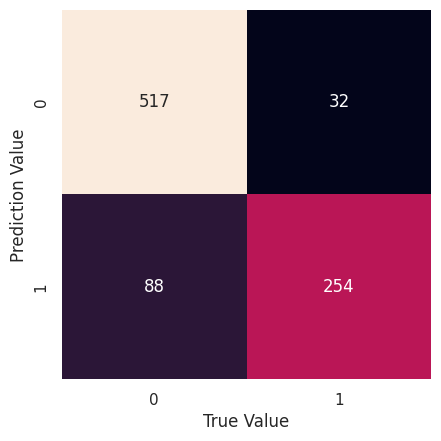

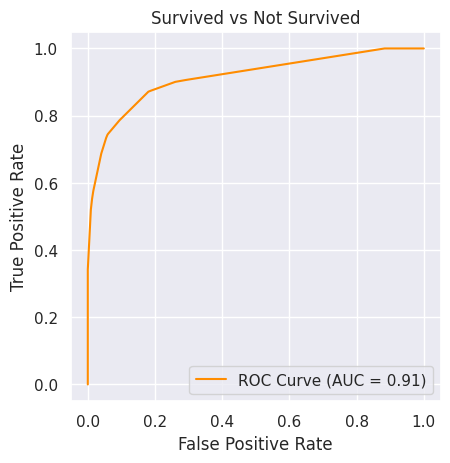


-------- Evaluating <class 'sklearn.ensemble._forest.RandomForestClassifier'> --------
The selected parameters are {'bootstrap': False, 'max_features': 6, 'n_estimators': 12}
The precision on the training set using CV : 0.806
Binary Precision_score :  0.9939024390243902
Weighted Precision_score :  0.9801487123542315
Average_precision_score :  0.9653614305946356
Binary f1_score :  0.973134328358209
Weighted f1_score :  0.9797140849057524
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       563
           1       0.95      0.99      0.97       328

    accuracy                           0.98       891
   macro avg       0.97      0.98      0.98       891
weighted avg       0.98      0.98      0.98       891



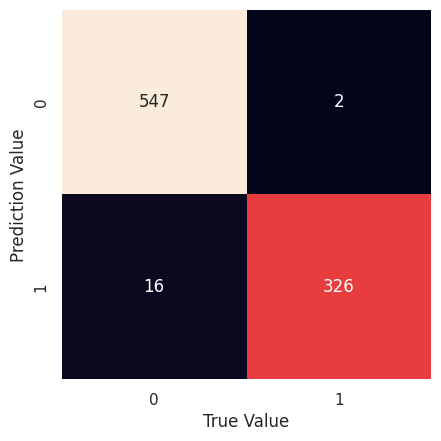

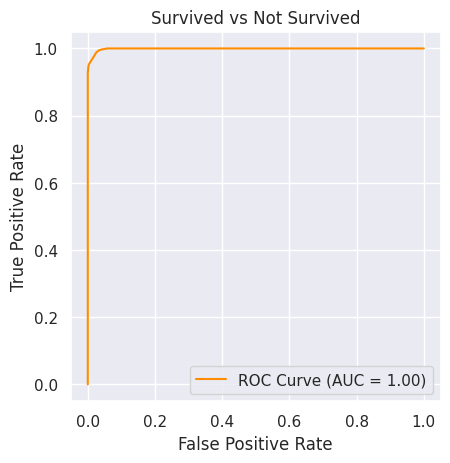


-------- Evaluating <class 'sklearn.neighbors._classification.KNeighborsClassifier'> --------
The selected parameters are {'n_neighbors': 25}
The precision on the training set using CV : 0.804
Binary Precision_score :  0.8096885813148789
Weighted Precision_score :  0.816410550457384
Average_precision_score :  0.6752095715854594
Binary f1_score :  0.7416798732171157
Weighted f1_score :  0.8135884851536233
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       602
           1       0.68      0.81      0.74       289

    accuracy                           0.82       891
   macro avg       0.79      0.82      0.80       891
weighted avg       0.83      0.82      0.82       891



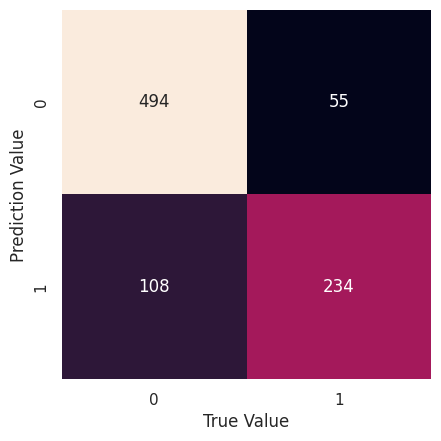

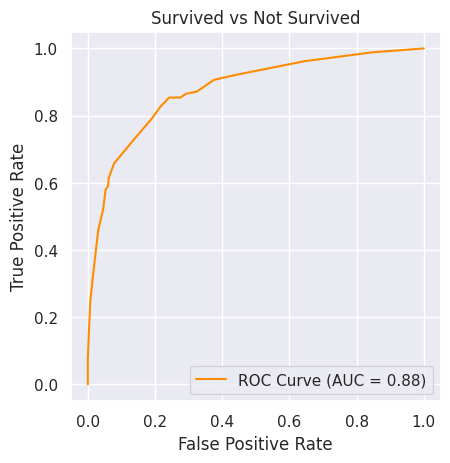


-------- Evaluating <class 'sklearn.svm._classes.SVC'> --------
The selected parameters are {'degree': 1, 'probability': True}
The precision on the training set using CV : 0.822
Binary Precision_score :  0.8131147540983606
Weighted Precision_score :  0.8294280577836779
Average_precision_score :  0.6951265119801213
Binary f1_score :  0.7666151468315301
Weighted f1_score :  0.8284440108827827
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       586
           1       0.73      0.81      0.77       305

    accuracy                           0.83       891
   macro avg       0.81      0.83      0.82       891
weighted avg       0.84      0.83      0.83       891



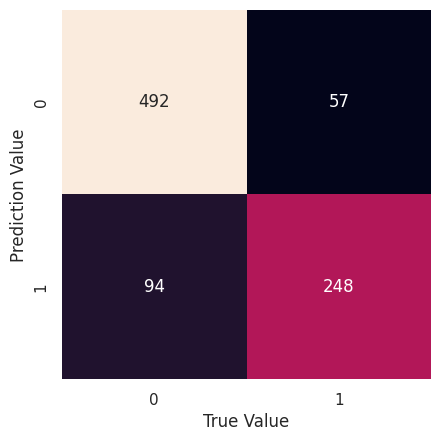

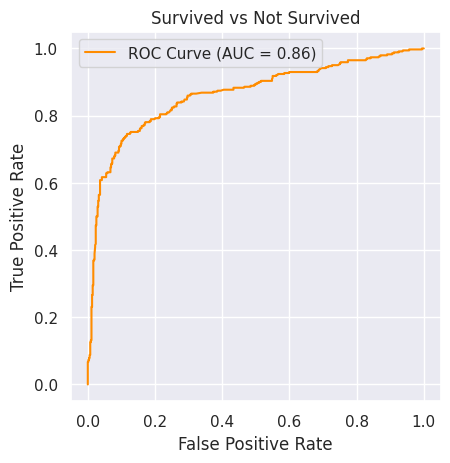


-------- Evaluating <class 'sklearn.linear_model._logistic.LogisticRegression'> --------
The selected parameters are {}
The precision on the training set using CV : 0.789
Binary Precision_score :  0.759493670886076
Weighted Precision_score :  0.7983827265500354
Average_precision_score :  0.6474561291350099
Binary f1_score :  0.729483282674772
Weighted f1_score :  0.7985881049786554
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       575
           1       0.70      0.76      0.73       316

    accuracy                           0.80       891
   macro avg       0.78      0.79      0.79       891
weighted avg       0.80      0.80      0.80       891



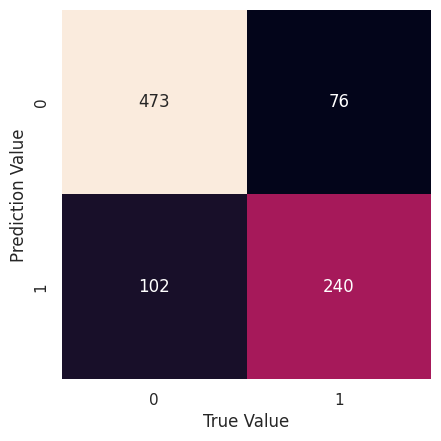

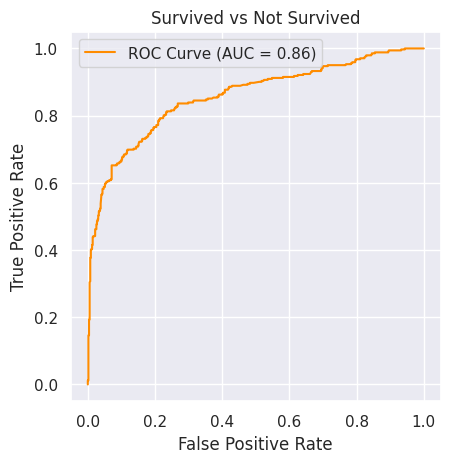

In [47]:
for model, param_grid in zip(models, parameters):
    print('\n-------- Evaluating {} --------'.format(type(model)))
    # It made the parameters exploration for each model.
    model_gs = GridSearchCV(
                # Model to try the parameters, parameters to try.
                model,
                param_grid,
                refit=True,
                verbose=0,
                cv=5,
                scoring='accuracy'
            )

    #X_train, X_test, y_train, y_test = train_test_split(X_train_titanic_df, y_train_titanic_df, test_size = 0.25, random_state = 1)

    # Switch to save the best parameters for each model.
    match model:
      case DecisionTreeClassifier():
        best_tree_class = model_gs
      case RandomForestClassifier():
        best_rf_class = model_gs
      case KNeighborsClassifier():
        best_knn_class = model_gs
      case SVC():
        best_svm_class = model_gs
      case LogisticRegression():
        best_log_reg = model_gs

    # Training each model based on the best one.
    model_gs.fit(X_train_titanic_df, y_train_titanic_df.values.ravel())

    # Making predictions for the model selected.
    y_pred = model_gs.predict(X_train_titanic_df)

    print('The selected parameters are {}'.format(model_gs.best_params_))

    best_model_index = np.argmin(model_gs.cv_results_['rank_test_score'])

    print('The precision on the training set using CV : {:.3f}'.format(
        model_gs.cv_results_['mean_test_score'][best_model_index]
    ))

    print('Binary Precision_score : ', precision_score(y_train_titanic_df, y_pred, average = 'binary'))
    print('Weighted Precision_score : ', precision_score(y_train_titanic_df, y_pred, average = 'weighted'))
    print('Average_precision_score : ', average_precision_score(y_train_titanic_df, y_pred))
    print('Binary f1_score : ', f1_score(y_train_titanic_df, y_pred, average = 'binary'))
    print('Weighted f1_score : ', f1_score(y_train_titanic_df, y_pred, average = 'weighted'))

    print(classification_report(y_pred, y_train_titanic_df))

    # Plotting the Confusion Matrix.
    sns.heatmap(confusion_matrix(y_pred, y_train_titanic_df).T, square = True, annot = True, fmt = 'd', cbar = False)
    plt.xlabel('True Value')
    plt.ylabel('Prediction Value');
    plt.show()

    # Plotting the ROC Curve.
    y_proba = model_gs.predict_proba(X_train_titanic_df)[:, 1]
    ns_proba = [0 for _ in range (len(y_train_titanic_df))]

    RocCurveDisplay.from_predictions(
      y_train_titanic_df,
      y_proba,
      name="ROC Curve",
      color="darkorange",
    )
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Survived vs Not Survived")
    plt.legend()
    plt.show()

After making the iteration in order to obtain the best model and we already saved it on a variable, we use this section only to confirmed that our best model is within that variable for us to use it to make the predictions for the testing dataset.

In [49]:
# Show which parameters were the best for each model.
print('Selected Parameters for DecisionTrees {}'.format(best_tree_class.best_params_))
print('Selected Parameters for Random Forets {}'.format(best_rf_class.best_params_))
print('Selected Parameters for k-Nearest Neighbours {}'.format(best_knn_class.best_params_))
print('Selected Parameters for Support Vector Machine {}'.format(best_svm_class.best_params_))
print('Selected Parameters for Logistic Regression {}'.format(best_log_reg.best_params_))

Selected Parameters for DecisionTrees {'max_depth': 6}
Selected Parameters for Random Forets {'bootstrap': False, 'max_features': 6, 'n_estimators': 12}
Selected Parameters for k-Nearest Neighbours {'n_neighbors': 25}
Selected Parameters for Support Vector Machine {'degree': 1, 'probability': True}
Selected Parameters for Logistic Regression {}


---
---
---
---

**Decision Tree Classifier :**
The Decision Tree Classifier gets a pretty good precision and F1 score. It performs well in classifying survival AND non-survival cases.
The average precision score is also acceptable, it shows good performance in ran
It seems like a solid choice for this dataset.

**Random Forest Classifier :**
The Random Forest Classifier gets excellent performance with precision and F1 score. It performs nearly perfect precision, that shows a low rate of false positives. The average precision score is also high, indicating good ranking of predictions.
This model seams like a strong candidate for this dataset.

**KNN :**
The KNN Classifier gets a lower precision and F1 score compared to the other models.
The average precision score is also lower, this suggest that it may not be as effective in ranking predictions.
It might not be the best-performing model for this dataset.

**SVC :**
The SVC shows good precision and F1 score, although slightly lower than the Random Forest and Decision Tree models. The average precision score is also lower, indicating that it might not perform as well in ranking predictions.
It seems like a decent choice, but still less than the two first models.

**Logistic Regression :**
The Logistic Regression model achieves a decent precision and F1 score. But it has the lowest average precision score among the models, indicating that it may not rank predictions as effectively as others.

---

According to the metrics provided, the **Random Forest Classifier** stands out as the best performer, closely followed by the Decision Tree Classifier and the Support Vector Classifier.

 These models have good accuracy, the highest F1 scores and the highest average accuracy scores.
In terms of predictive performance, Random Forest seems to be the most promising option for this dataset's classification problem.

---
---
---
---

## 3) Exploration and Data Pre-processing for Testing Dataset.

---
---



#### a) Distributions.

---

For now on, we only repeating the same process that we follow for the training test, we first of all recognize if the testing dataset has the same missing values on the same features, in our case we encounter that the age and cabin features have also missing values in our testing dataset so we already made a decision on how we are managing this missing values. <br></br>
But also, we found that we have now missing values on fare feature, so we have to analyze the dataset in order to make a decision on how we are filling this value. And keeping the same features/structure that we have in our training dataset, so we are preparing our final dataset in which we are going to make the predictions if the passenger survived or not.

In [50]:
# Reorganizing dataset only for visual purposes.
test_titanic_df = test_titanic_df[["PassengerId", "Name", "Sex", "Age", "Pclass", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"]]

In [51]:
# Showing information about the dataset.
test_titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Name         418 non-null    object 
 2   Sex          418 non-null    object 
 3   Age          332 non-null    float64
 4   Pclass       418 non-null    int64  
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [52]:
# Show how distributed "Sex" feature is within the dataset.
test_titanic_df["Sex"].value_counts()

male      266
female    152
Name: Sex, dtype: int64

In [53]:
# Show how distributed "Ticket" feature is within the dataset.
test_titanic_df["Ticket"].value_counts()

PC 17608    5
CA. 2343    4
113503      4
PC 17483    3
220845      3
           ..
349226      1
2621        1
4133        1
113780      1
2668        1
Name: Ticket, Length: 363, dtype: int64

In [54]:
# Show how distributed "Cabin" feature is within the dataset.
test_titanic_df["Cabin"].value_counts()

B57 B59 B63 B66    3
B45                2
C89                2
C55 C57            2
A34                2
                  ..
E52                1
D30                1
E31                1
C62 C64            1
C105               1
Name: Cabin, Length: 76, dtype: int64

In [55]:
# Show how distributed "Embarked" feature is within the dataset.
test_titanic_df["Embarked"].value_counts()

S    270
C    102
Q     46
Name: Embarked, dtype: int64

In [56]:
# Showing statistics about the dataset.
test_titanic_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,418.0,1100.500000,120.810458,892.00,996.2500,1100.5000,1204.75,1309.0000
Age,332.0,30.272590,14.181209,0.17,21.0000,27.0000,39.00,76.0000
Pclass,418.0,2.265550,0.841838,1.00,1.0000,3.0000,3.00,3.0000
SibSp,418.0,0.447368,0.896760,0.00,0.0000,0.0000,1.00,8.0000
Parch,418.0,0.392344,0.981429,0.00,0.0000,0.0000,0.00,9.0000
Fare,417.0,35.627188,55.907576,0.00,7.8958,14.4542,31.50,512.3292


array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'Pclass'}>,
        <Axes: title={'center': 'SibSp'}>],
       [<Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'Fare'}>]], dtype=object)

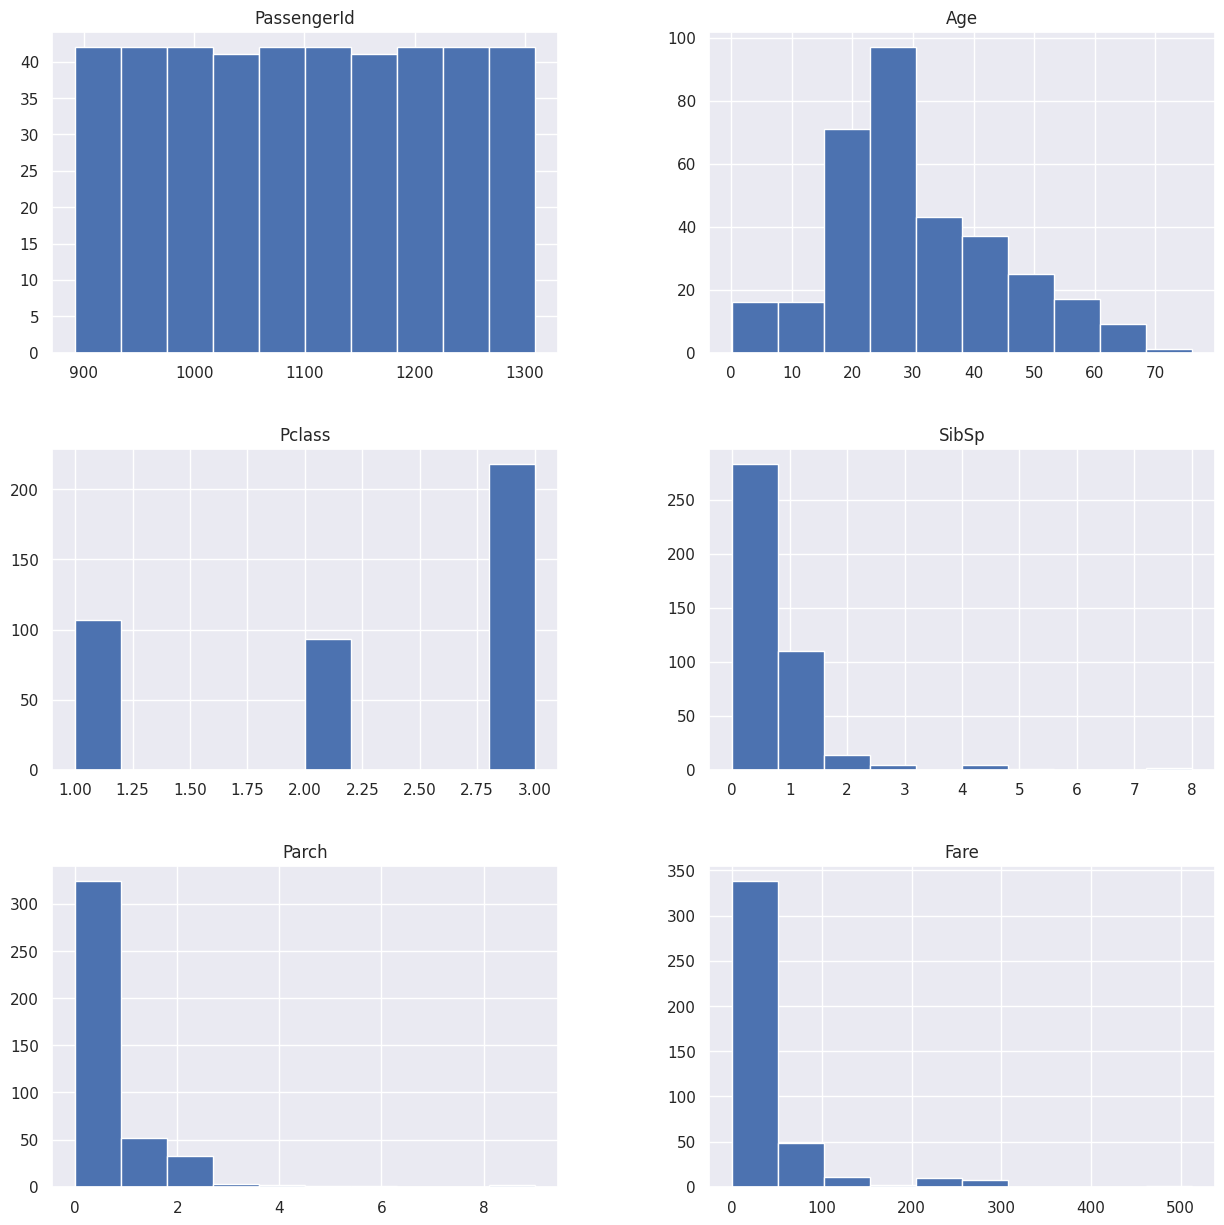

In [57]:
# Showing the distribution throughout the dataset.
test_titanic_df.hist(figsize = (15, 15), bins = 10)

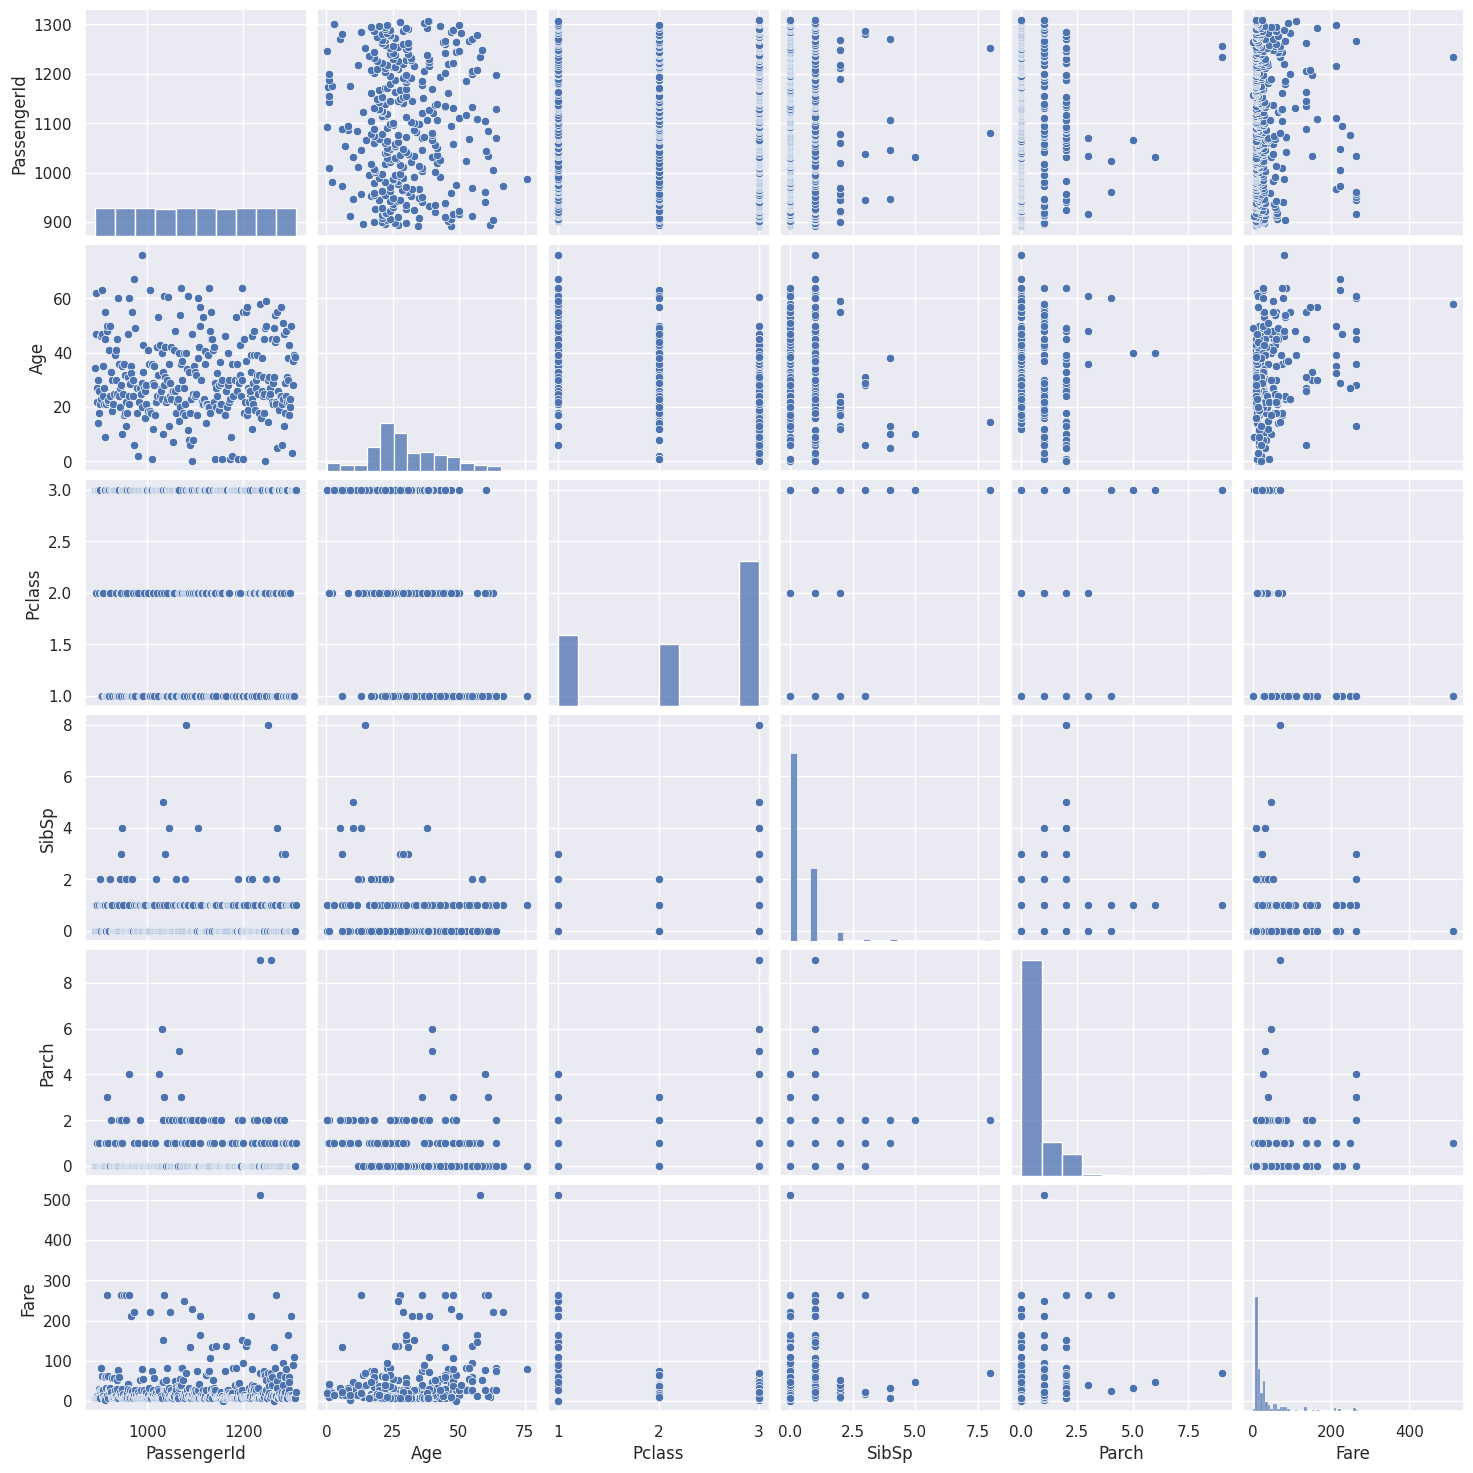

In [58]:
sns.pairplot(test_titanic_df)

#### b) Missing values.

---
Our cabin feature is again our feature with most missing values, but since we already made the decision on dropping the feature we don't hace to worry on how we are managing the missing values. We only looking for the age and the fare features because those are the ones we are taking into an account for our model. In the case of age, we already made the decision that based on the distribution we are using the median for filling the missing values. <br></br>
On the other hand, the fare feature is only missing one value, so it doesn't really seems to have any impact in how we fill the value, but since the distribution on this feature is clearly skewed, we decided to use the mode to fill the missing value but we could also use the median.

In [59]:
# Identify if any feature has missing values.
test_titanic_df.isnull().sum()

PassengerId      0
Name             0
Sex              0
Age             86
Pclass           0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

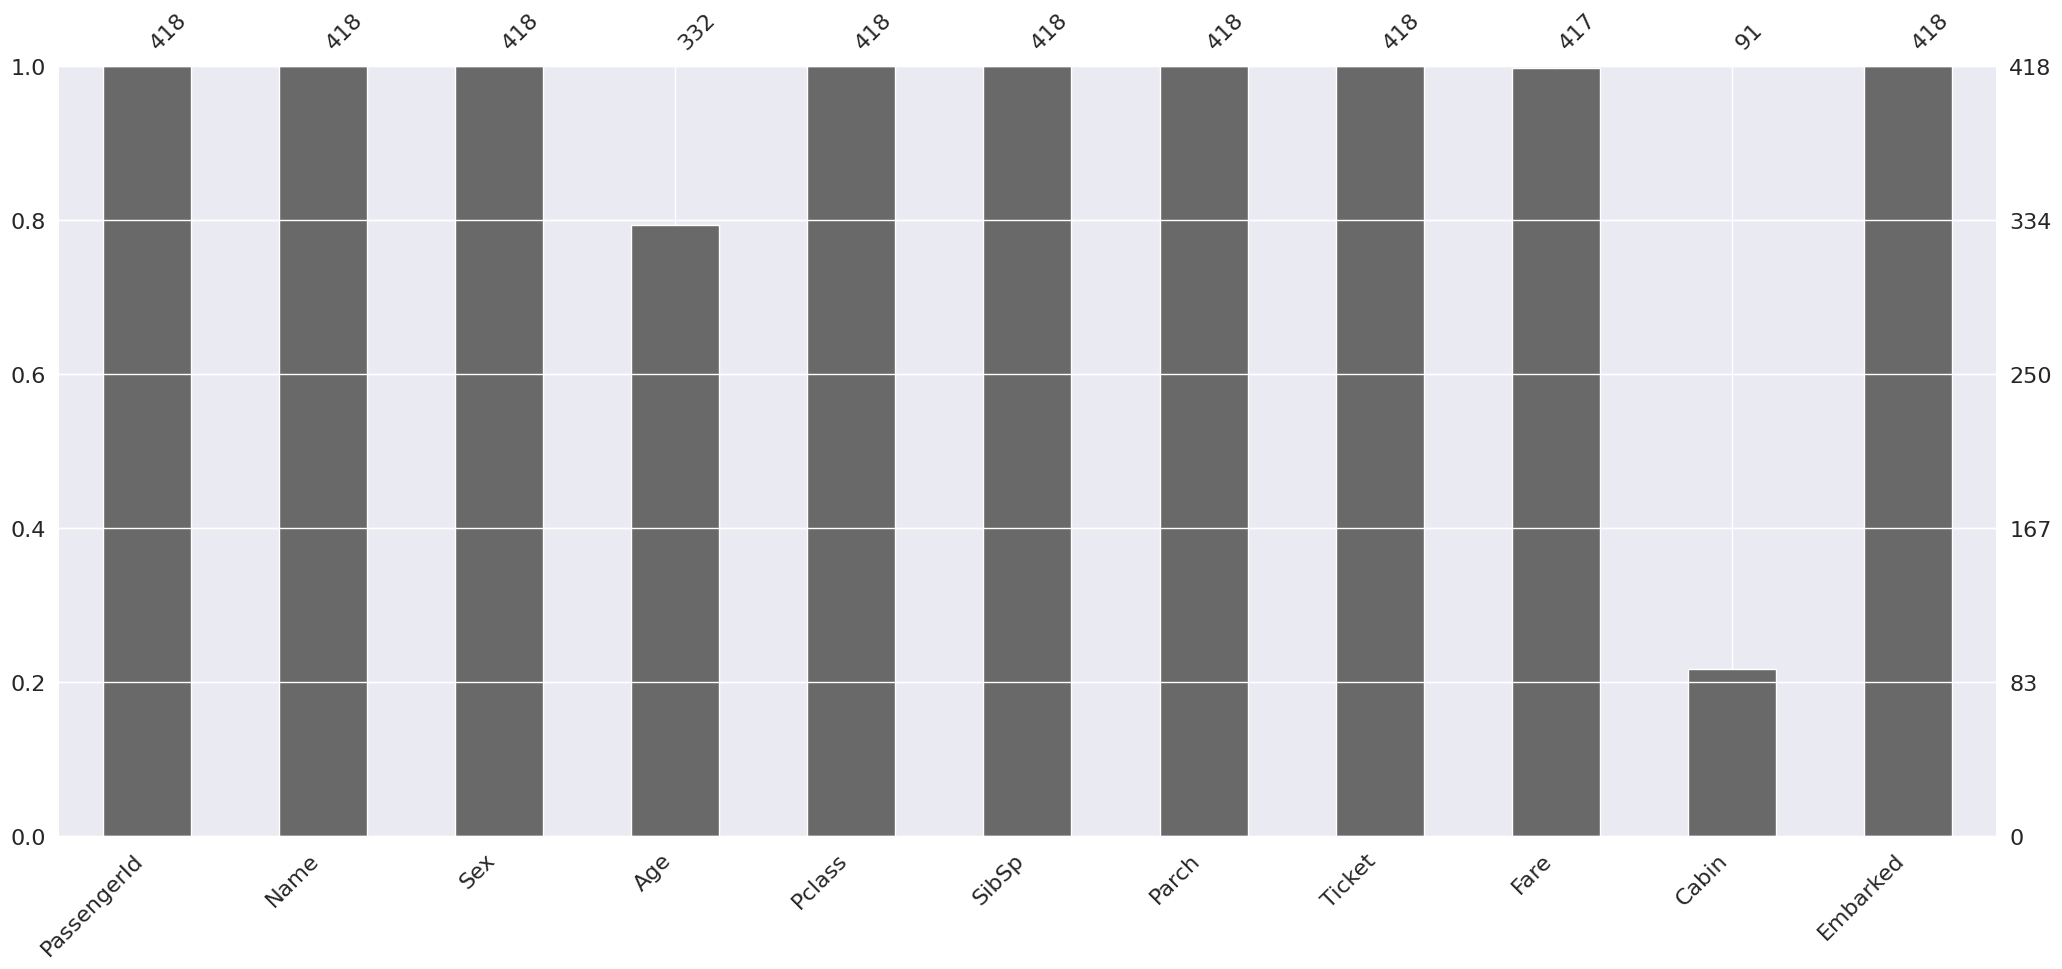

In [60]:
# Verify the missing values of the dataset.
missing_values = msno.bar(test_titanic_df)

In [61]:
# Obtain the thresholds that will say if a value is an outlier.
outlier_test_titanic_df = test_titanic_df[["Pclass","Age","SibSp","Parch","Fare"]]

for i in outlier_test_titanic_df.columns:
    print("Thresholds of {} : ({:.2f}, {:.2f})".format(i, *outlier_thresholds(outlier_test_titanic_df, i)))

Thresholds of Pclass : (-2.00, 6.00)
Thresholds of Age : (-6.00, 66.00)
Thresholds of SibSp : (-1.50, 2.50)
Thresholds of Parch : (0.00, 0.00)
Thresholds of Fare : (-27.51, 66.91)


In [62]:
# Verify number of outliers for numerical features.
outliers_encounters(test_titanic_df, "Pclass")
outliers_encounters(test_titanic_df, "Age")
outliers_encounters(test_titanic_df, "SibSp")
outliers_encounters(test_titanic_df, "Parch")
outliers_encounters(test_titanic_df, "Fare")

Number of outliers for Pclass: 0
Number of outliers for Age: 2
Number of outliers for SibSp: 11
Number of outliers for Parch: 94
Number of outliers for Fare: 55


In [63]:
# Obtain a missing values per feature table.
na_cols = missing_values_table(test_titanic_df, True)

       n_miss  ratio
Cabin     327  78.23
Age        86  20.57
Fare        1   0.24


In [64]:
# Fill the missing values of the features that we are going to keep.
test_titanic_df['Age'].fillna(test_titanic_df['Age'].median(), inplace=True)
test_titanic_df['Fare'].fillna(test_titanic_df['Fare'].mode()[0], inplace=True)

#### d) Data Transformation.

---

Once we already managed the missing values for the testing dataset, it's only left for us to applied the same data transformation to our dataset that we use for our training dataset, so in order to have ready our testing dataset we proceed to make the respective transformations.

In [65]:
# Transforming sex categories into numerical here only to appear in plotting charts.
test_titanic_df["isFemale"] = test_titanic_df.apply(isFemale, axis = 1)

# Drop the features that we are not going to use and review the transformation of Sex.
test_titanic_df = test_titanic_df.drop(["PassengerId", "Name", "Sex", "Ticket", "Cabin"], axis = 1)
test_titanic_df["isFemale"].value_counts()

0    266
1    152
Name: isFemale, dtype: int64

In [66]:
# Make a standarization on the features.
scaler = StandardScaler()
features = ['Age', 'SibSp', 'Parch', 'Fare']
test_titanic_df[features] = scaler.fit_transform(test_titanic_df[features])

test_titanic_df = pd.get_dummies(test_titanic_df, columns=['Embarked'], prefix=['Embarked'])

test_titanic_df = test_titanic_df[["Age", "Pclass", "SibSp", "Parch", "Fare", "Embarked_C", "Embarked_Q", "Embarked_S", "isFemale"]]
test_titanic_df.head(2)

,Age,Pclass,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,isFemale
0,0.386231,3,-0.499470,-0.400248,-0.497063,0,1,0,0
1,1.371370,3,0.616992,-0.400248,-0.511926,0,0,1,1


In [67]:
# Showing information about the dataset.
test_titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         418 non-null    float64
 1   Pclass      418 non-null    int64  
 2   SibSp       418 non-null    float64
 3   Parch       418 non-null    float64
 4   Fare        418 non-null    float64
 5   Embarked_C  418 non-null    uint8  
 6   Embarked_Q  418 non-null    uint8  
 7   Embarked_S  418 non-null    uint8  
 8   isFemale    418 non-null    int64  
dtypes: float64(4), int64(2), uint8(3)
memory usage: 20.9 KB


## 4) Predictions for Testing Dataset.

---



---




Finally, once we have finished visualizing, cleaning and transforming our training dataset, it is only necessary to use the best algorithm models to make the predictions if the passenger survived or not. <br></br>
To do this we will use an auxiliary function whose execution will test the training dataset in the model, show the model score and also generate a csv file storing the predictions obtained for each given model, in this case, they will be tested for the following models:
<ul>
  <li>Decision Tree Model</li>
  <li>Random Forest Model</li>
  <li>k-Nearest Neighbours Model</li>
  <li>Support Vector Machine Model</li>
  <li>Logistic Regression Model</li>
</ul>

And we will be obtaining the following csv's :

<ul>
  <li>DecisionTreePredictions.csv</li>
  <li>RandomForestPredictions.csv</li>
  <li>kNNPredictions.csv</li>
  <li>SVCPredictions.csv</li>
  <li>LogisticRegressionPredictions.csv</li>
</ul>

And these csv's are going to be useful in order to make a submission on kaggle and it will gives us a score on how our model is making the predictions if a passenger survived or not. <br></br>
For greater ease, the results of our models once we upload them to Kaggle are appended to the end of the next execution.

In [74]:
# Reloading the testing dataset and splitting it into features and target class.
X_test_titanic_df = test_titanic_df

In [75]:
# Evaluate the performance of the Decision Tree Model on the testing dataset.
evaluate_best_models(best_tree_class, X_test_titanic_df, 1)

----------------- MEAN -----------------
Mean_test_score : 0.7971646475425271
Std_test_score : 0.02690900623061506
----------------- ONLY 1 -----------------
Mean_test_score : 0.7867365513778168
Std_test_score : 0.018667207932566335


In [76]:
# Evaluate the performance of the Random Forest Model on the testing dataset.
evaluate_best_models(best_rf_class, X_test_titanic_df, 2)

----------------- MEAN -----------------
Mean_test_score : 0.7993147532065366
Std_test_score : 0.026646326552224677
----------------- ONLY 1 -----------------
Mean_test_score : 0.797991337643588
Std_test_score : 0.02263799465250136


In [77]:
# Evaluate the performance of the k-Nearest Neighbours Model on the testing dataset.
evaluate_best_models(best_knn_class, X_test_titanic_df, 3)

----------------- MEAN -----------------
Mean_test_score : 0.7914138651506049
Std_test_score : 0.02447707690939917
----------------- ONLY 1 -----------------
Mean_test_score : 0.7318059129998118
Std_test_score : 0.032219083708729314


In [78]:
# Evaluate the performance of the Support Vector Machine Model on the testing dataset.
evaluate_best_models(best_svm_class, X_test_titanic_df, 4)

----------------- MEAN -----------------
Mean_test_score : 0.8215491808423827
Std_test_score : 0.012995405474709435
----------------- ONLY 1 -----------------
Mean_test_score : 0.8215491808423827
Std_test_score : 0.012995405474709435


In [79]:
# Evaluate the performance of the Logistic Regression Model on the testing dataset.
evaluate_best_models(best_log_reg, X_test_titanic_df, 5)

----------------- MEAN -----------------
Mean_test_score : 0.7890151277383717
Std_test_score : 0.019488362104751616
----------------- ONLY 1 -----------------
Mean_test_score : 0.7890151277383717
Std_test_score : 0.019488362104751616


## 5) Kaggle Scores of each Model Predictions.

---



---




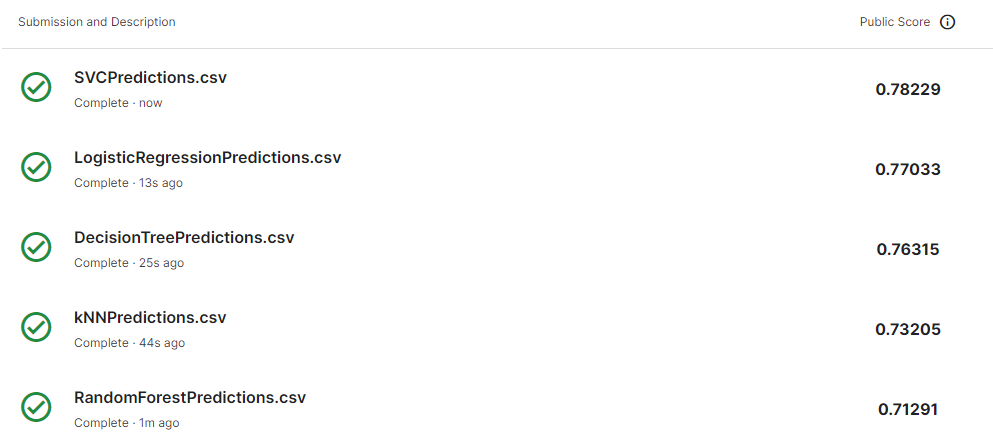